<a href="https://colab.research.google.com/github/notKguin/MMK-Informservice/blob/main/final_project/project/ML_intensive_final_project_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%config InlineBackend.figure_format='retina'

## Импорт библиотек

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    r2_score
)
from sklearn.preprocessing import StandardScaler

# Загрузка датасета

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df_chugun = pd.read_csv('/content/drive/MyDrive/MMK_inforservice/datasets/ML_intensive_final_project_correlation_chugun.csv')

In [5]:
df_coke = pd.read_csv('/content/drive/MyDrive/MMK_inforservice/datasets/ML_intensive_final_project_correlation_coke.csv')

## Разделение данных для «Количество чугуна (т)»

In [6]:
target_1 = 'Количество чугуна (т)'
X_chugun = df_chugun.drop(target_1, axis=1)
y_chugun = df_chugun[target_1]

## Разделение данных для «Удельный расход кокса (кг/т)»

In [7]:
target_2 = 'Удельный расход кокса (кг/т)'
X_coke = df_coke.drop(target_2, axis=1)
y_coke = df_coke[target_2]

## Функция для вычисления и вывода метрик модели

In [8]:
def evaluate_model(y_test, y_pred, verbose=True):
    metrics = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'MAPE': mean_absolute_percentage_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R2': r2_score(y_test, y_pred)
    }

    if verbose:
        print("Метрики модели:")
        print(f"MAE: {metrics['MAE']:.2f}")
        print(f"MSE: {metrics['MSE']:.2f}")
        print(f"MAPE: {metrics['MAPE']:.2f}%")
        print(f"RMSE: {metrics['RMSE']:.2f}")
        print(f"R²: {metrics['R2']:.2f}")

    return metrics

# Модели для таргета «Количество чугуна (т)»

## Масштабирование признаков

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_chugun, y_chugun, test_size=0.2, random_state=42)

In [10]:
scaler = StandardScaler()

In [11]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Линейная регрессия

### Обучение модели и вывод метрик

In [12]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [13]:
y_pred = model.predict(X_test)

In [14]:
metrics = evaluate_model(y_test, y_pred)

Метрики модели:
MAE: 121.31
MSE: 25665.36
MAPE: 0.03%
RMSE: 160.20
R²: 0.94


### График Прогноз-Факт

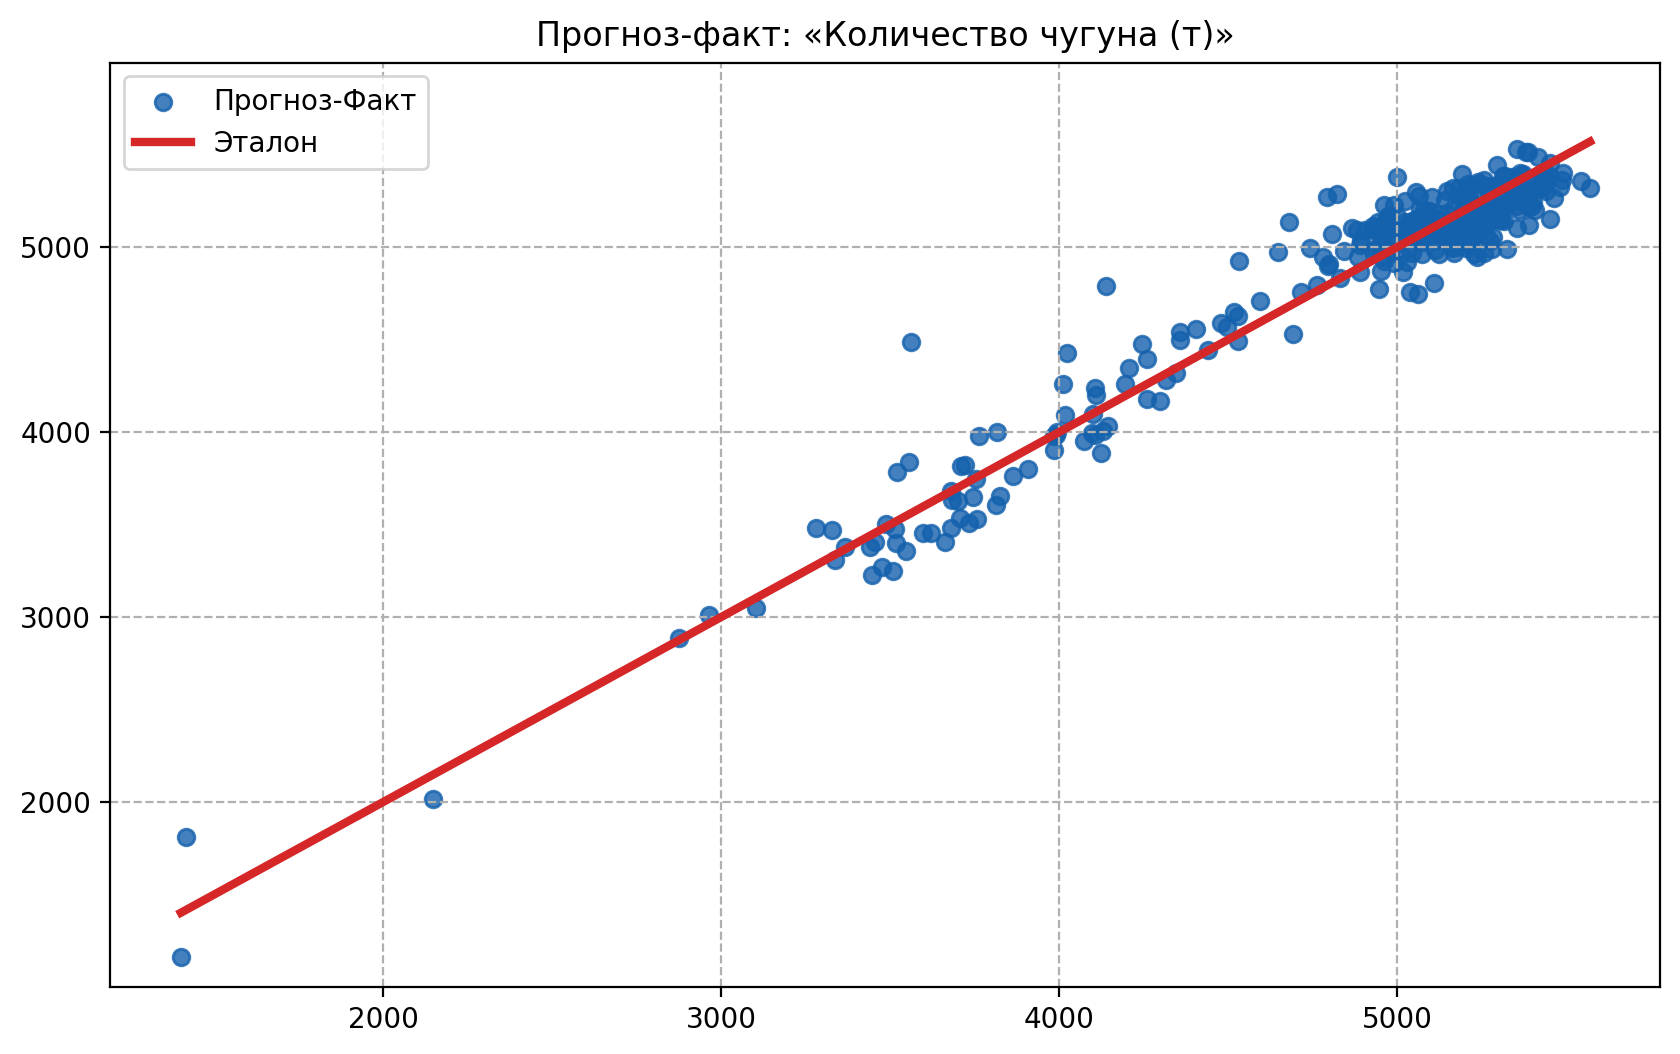

In [15]:
plt.figure(figsize=(10, 6))
plt.ylim(1001, 5999)
plt.scatter(y_test, y_pred, alpha = 0.8, color='#1461AD', label='Прогноз-Факт')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '-', linewidth=3, color='C13733', label='Эталон')
plt.xlabel(None)
plt.ylabel(None)
plt.title('Прогноз-факт: «Количество чугуна (т)»')
plt.legend()
plt.grid(linestyle='--')
plt.show()

### График влияния признаков

In [16]:
coefficients = pd.DataFrame({'Признак': X_chugun.columns,'Коэффициент': model.coef_}).sort_values(by='Коэффициент', ascending=True)

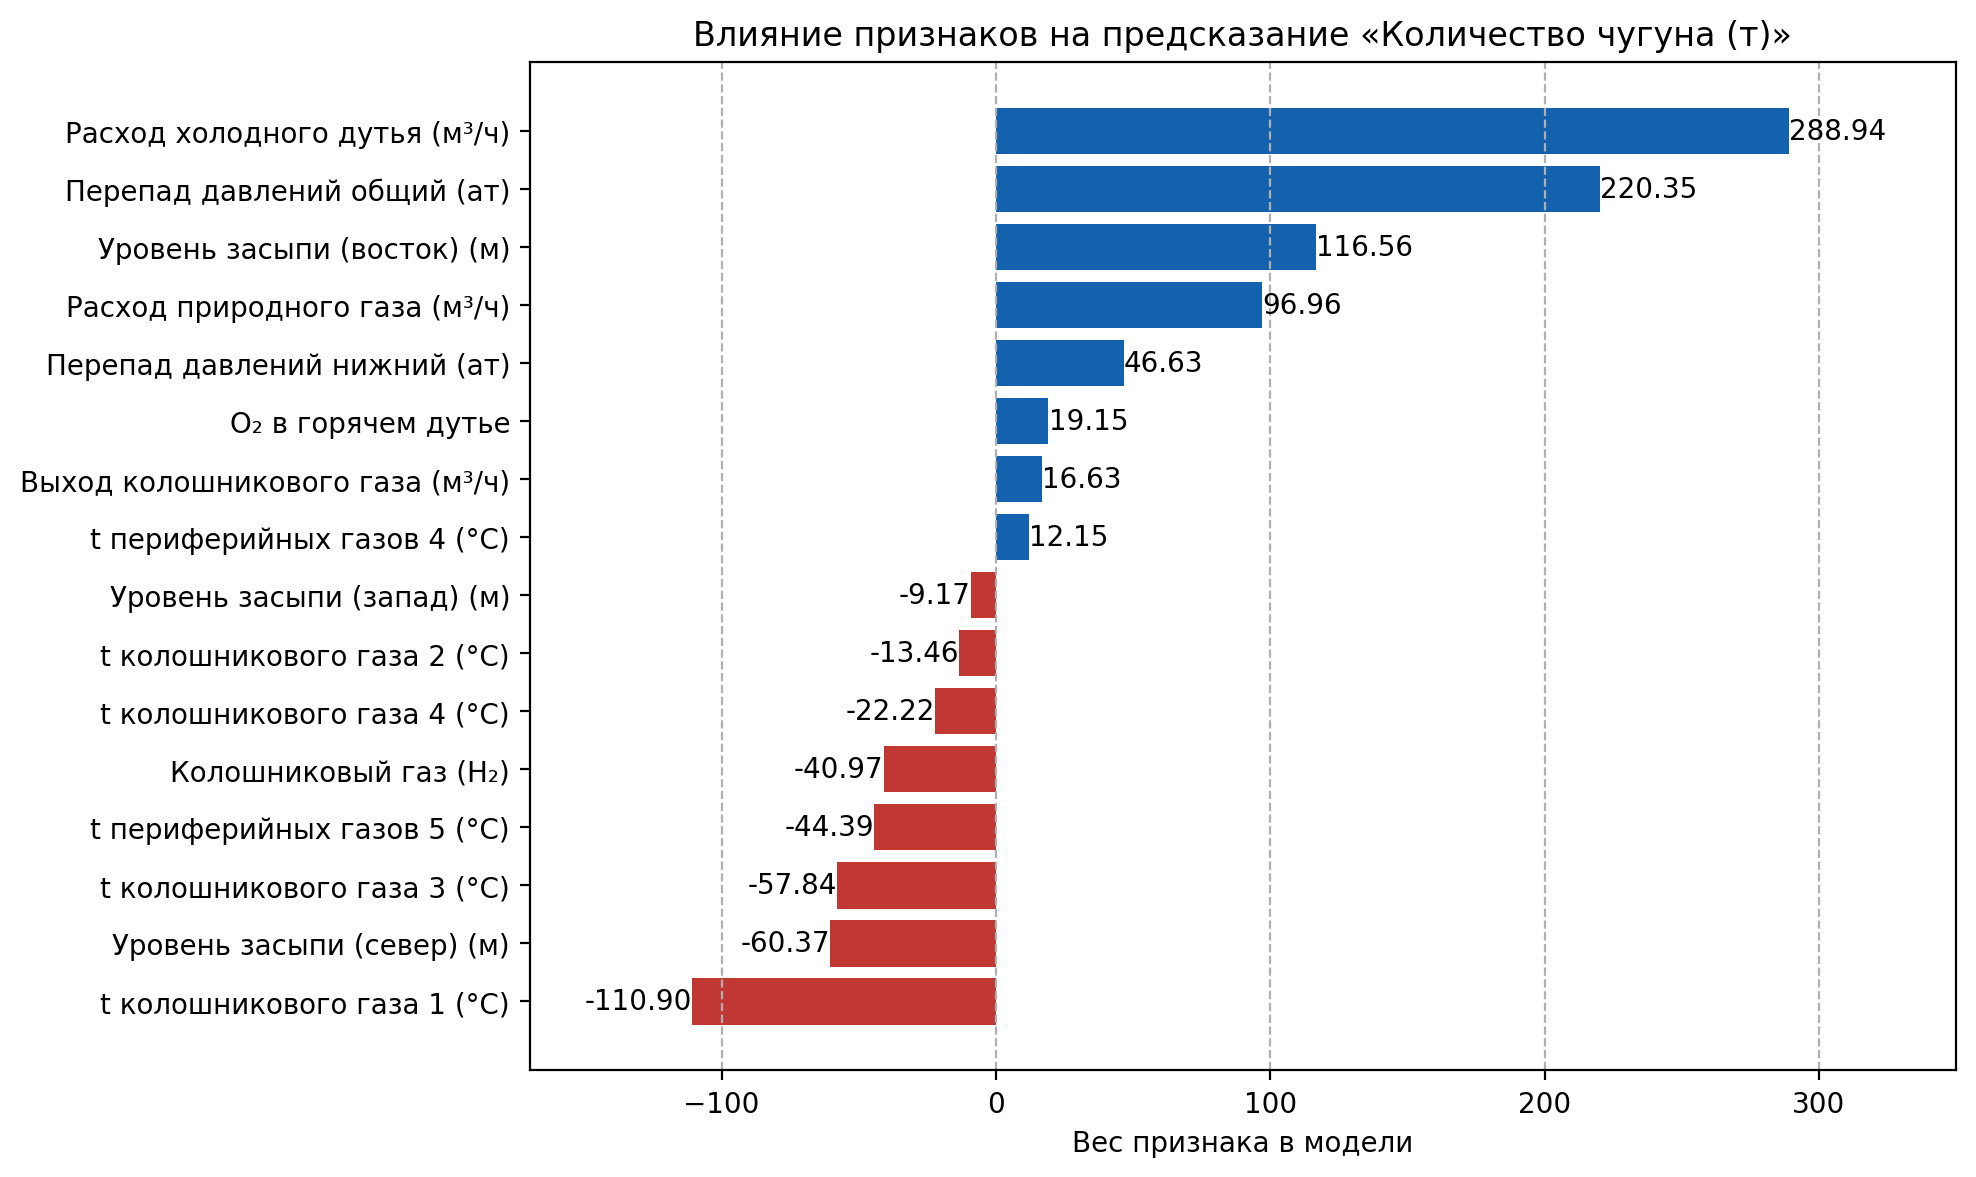

In [17]:
plt.figure(figsize=(10, 6))
plt.xlim(-170, 350)

colors = ['#1461AD' if x >= 0 else '#C13733' for x in coefficients['Коэффициент']]
bars = plt.barh(coefficients['Признак'], coefficients['Коэффициент'], color=colors)

for bar in bars:
    width = bar.get_width()
    align = 'left' if width > 0 else 'right'
    offset = 0.01 if width > 0 else -0.01
    plt.text(width + offset, bar.get_y() + bar.get_height()/2, f'{width:.2f}', ha=align, va='center')

plt.xlabel('Вес признака в модели')
plt.title('Влияние признаков на предсказание «Количество чугуна (т)»')
plt.grid(axis='x', linestyle='--', alpha=1)
plt.tight_layout()
plt.show()

## Дерево решений

### Подбор гиперпараметров

In [18]:
tree_model = DecisionTreeRegressor(random_state=42)

In [19]:
# param_grid = {
#     'max_depth': [8, 9, 10],
#     'max_features': ['sqrt', 'log2'],
#     'min_samples_leaf': [3, 4, 5],
#     'min_samples_split': [9, 10, 11]
# }

In [20]:
best_params = {
    'max_depth': [9],
    'max_features': ['sqrt'],
    'min_samples_leaf': [4],
    'min_samples_split': [10]
}

In [21]:
grid_search = GridSearchCV(
    estimator=tree_model,
    param_grid=best_params,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1
)

In [22]:
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


{'max_depth': 9,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 10}

### Обучение модели и вывод метрик

In [23]:
best_tree = grid_search.best_estimator_

In [24]:
y_pred = best_tree.predict(X_test)

In [25]:
metrics = evaluate_model(y_test, y_pred)

Метрики модели:
MAE: 122.34
MSE: 40607.58
MAPE: 0.03%
RMSE: 201.51
R²: 0.91


### График Прогноз-Факт

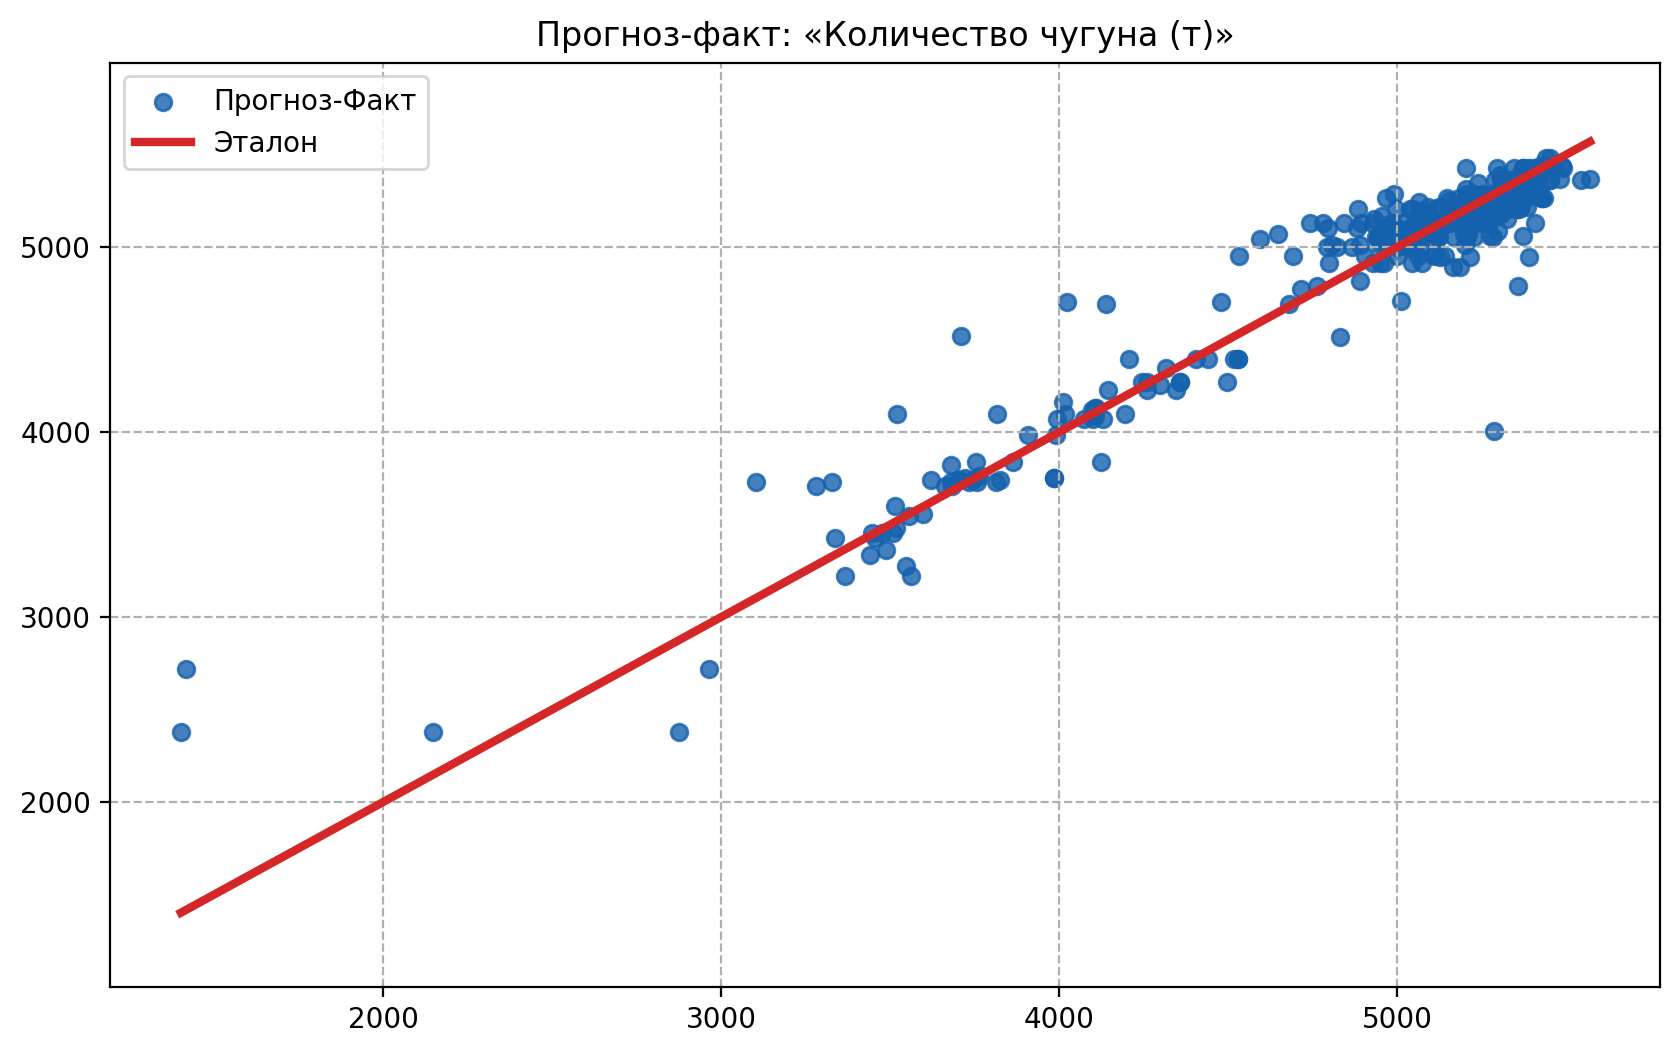

In [26]:
plt.figure(figsize=(10, 6))
plt.ylim(1001, 5999)
plt.scatter(y_test, y_pred, alpha = 0.8, color='#1461AD', label='Прогноз-Факт')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '-', linewidth=3, color='C13733', label='Эталон')
plt.xlabel(None)
plt.ylabel(None)
plt.title('Прогноз-факт: «Количество чугуна (т)»')
plt.legend()
plt.grid(linestyle='--')
plt.show()

### График важности признаков

In [27]:
importance = pd.DataFrame({'Признак': X_chugun.columns, 'Важность': best_tree.feature_importances_}).sort_values('Важность', ascending=True)

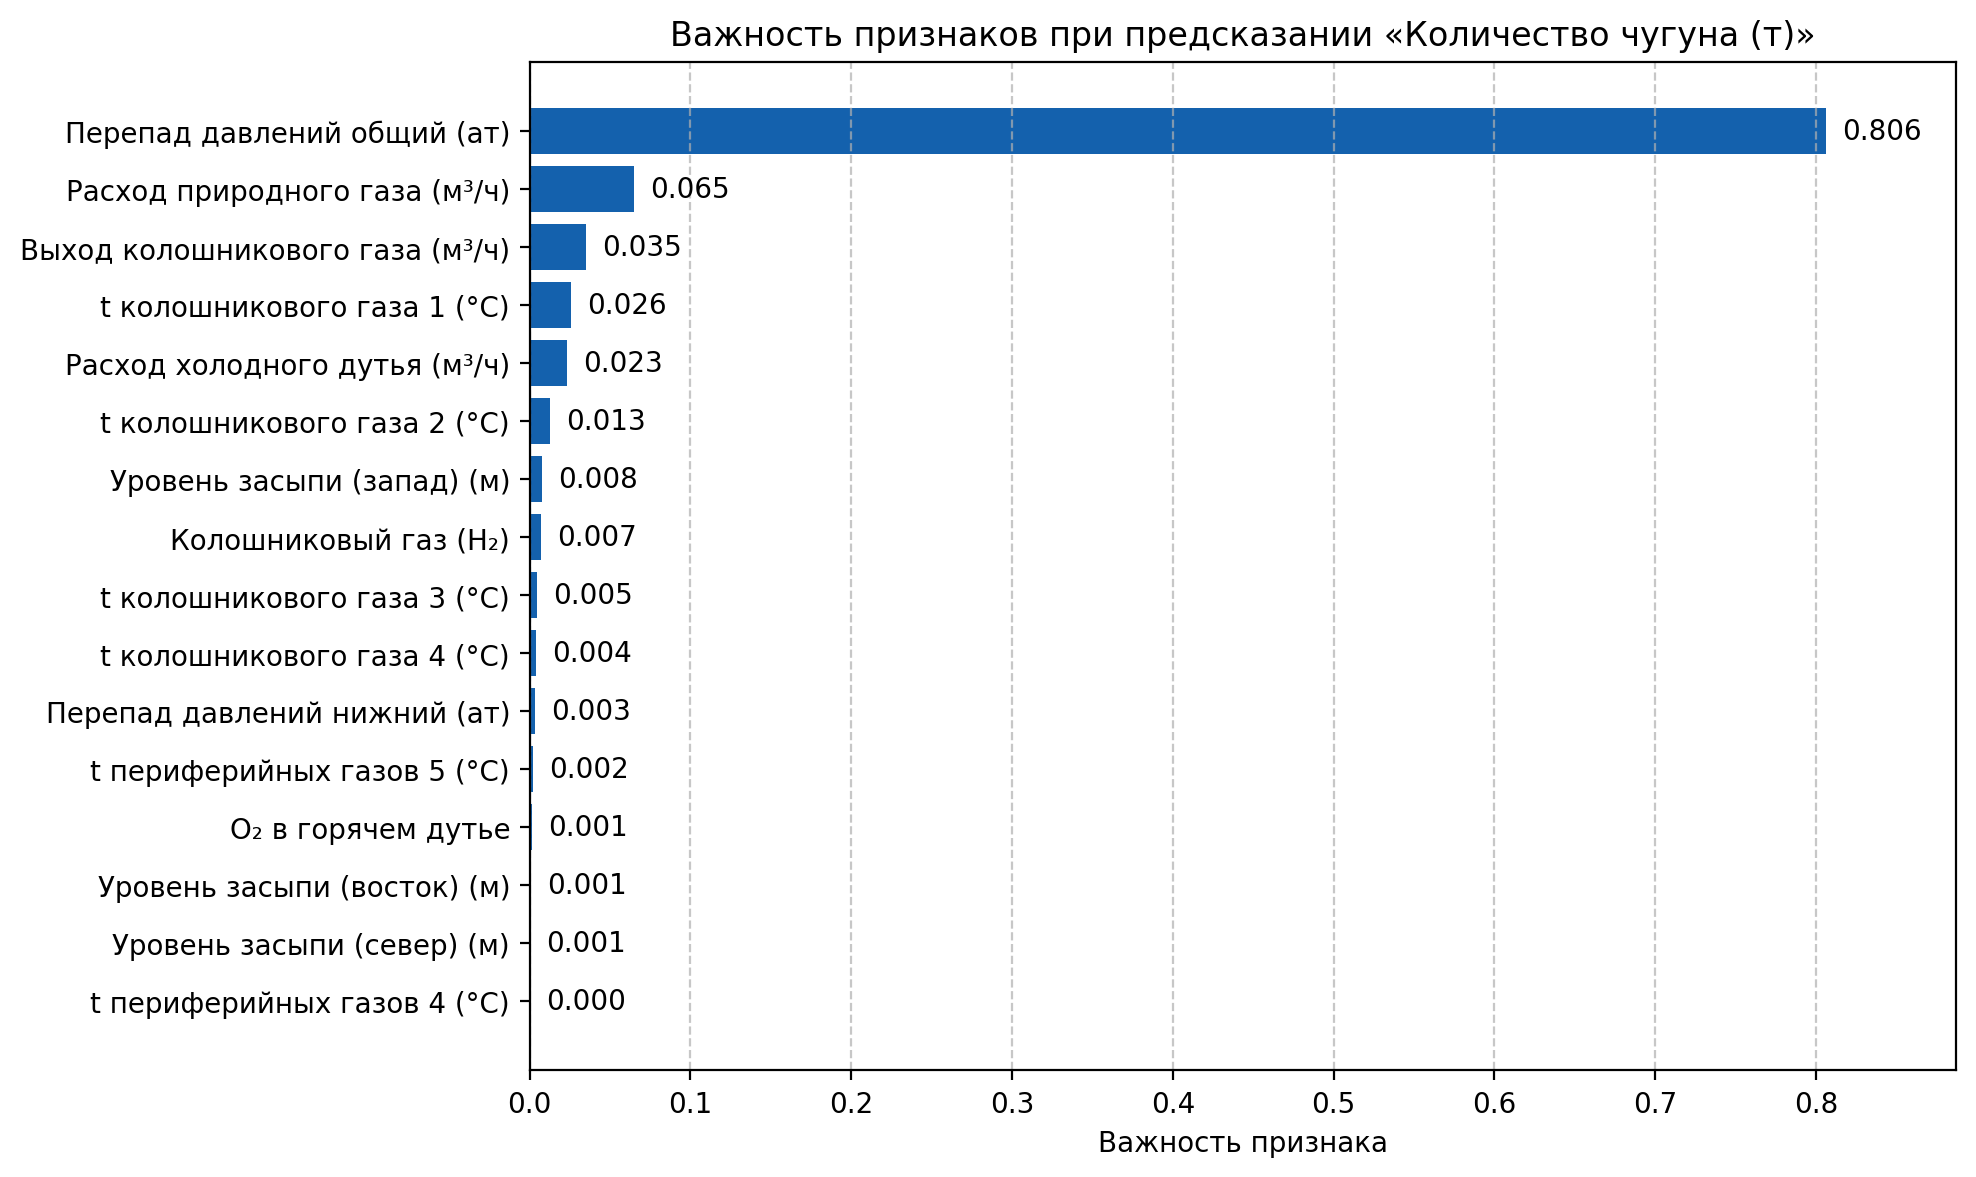

In [28]:
plt.figure(figsize=(10, 6))
plt.xlim(0, importance['Важность'].max() * 1.1)
bars = plt.barh(importance['Признак'], importance['Важность'], color='#1461AD')

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01,bar.get_y() + bar.get_height() / 2,f'{width:.3f}',ha='left',va='center')

plt.xlabel('Важность признака')
plt.title('Важность признаков при предсказании «Количество чугуна (т)»')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Визуализация дерева решений

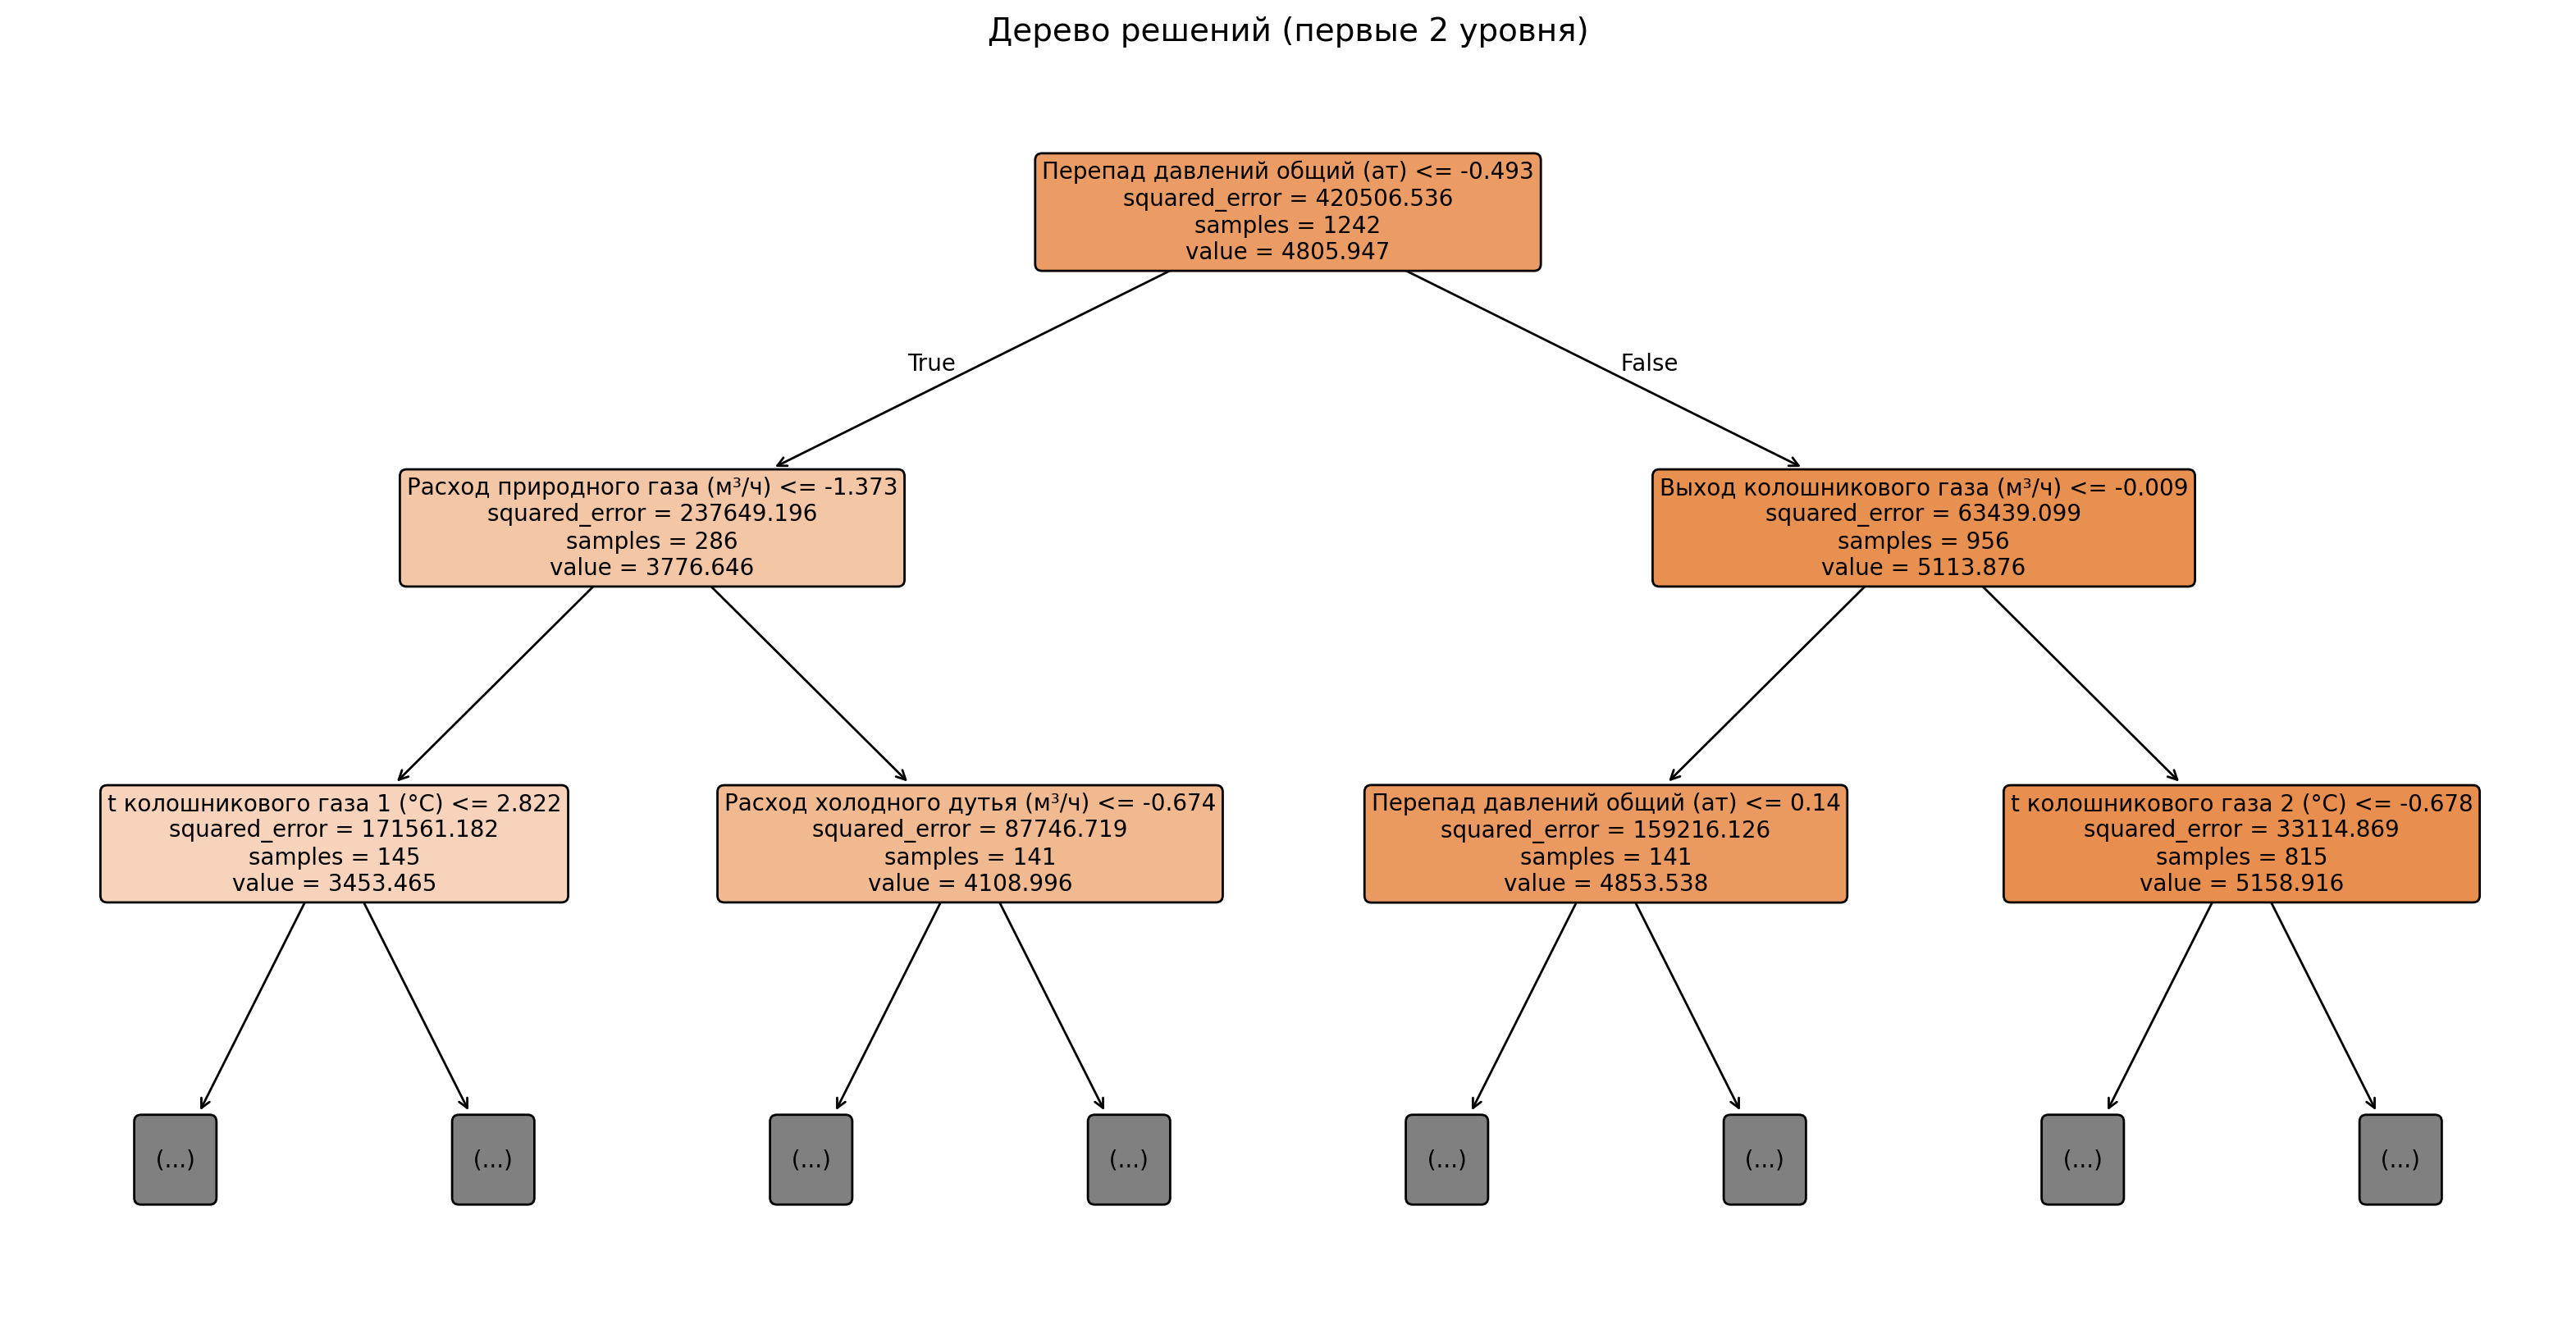

In [29]:
plt.figure(figsize=(20, 10))
plot_tree(
    best_tree,
    feature_names=importance['Признак'],
    filled=True,
    rounded=True,
    fontsize=10,
    max_depth=2,
)
plt.title("Дерево решений (первые 2 уровня)", fontsize=14)
plt.show()

## Градиентный бустинг

### Подбор гиперпараметров

In [30]:
gb_model = GradientBoostingRegressor(random_state=42)

In [31]:
# param_grid = {
#     'learning_rate': [0.08, 0.09, 0.1],
#     'max_depth': [3, 4, 5],
#     'max_features': ['sqrt', 'log2'],
#     'min_samples_leaf': [1, 2, 3],
#     'min_samples_split': [9, 10, 11],
#     'n_estimators': [400, 450, 500]
# }

In [32]:
best_params = {
    'learning_rate': [0.09],
    'max_depth': [4],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1],
    'min_samples_split': [10],
    'n_estimators': [450]
}

In [33]:
grid_search = GridSearchCV(
    estimator=gb_model,
    param_grid=best_params,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
)

In [34]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             param_grid={'learning_rate': [0.09], 'max_depth': [4],
                         'max_features': ['sqrt'], 'min_samples_leaf': [1],
                         'min_samples_split': [10], 'n_estimators': [450]},
             scoring='neg_mean_squared_error', verbose=1)

In [35]:
best_params = grid_search.best_params_
best_params

### Обучение модели и вывод метрик

In [36]:
best_gb = grid_search.best_estimator_

In [37]:
y_pred = best_gb.predict(X_test)

In [38]:
metrics = evaluate_model(y_test, y_pred)

Метрики модели:
MAE: 82.02
MSE: 12881.30
MAPE: 0.02%
RMSE: 113.50
R²: 0.97


### График Прогноз-Факт

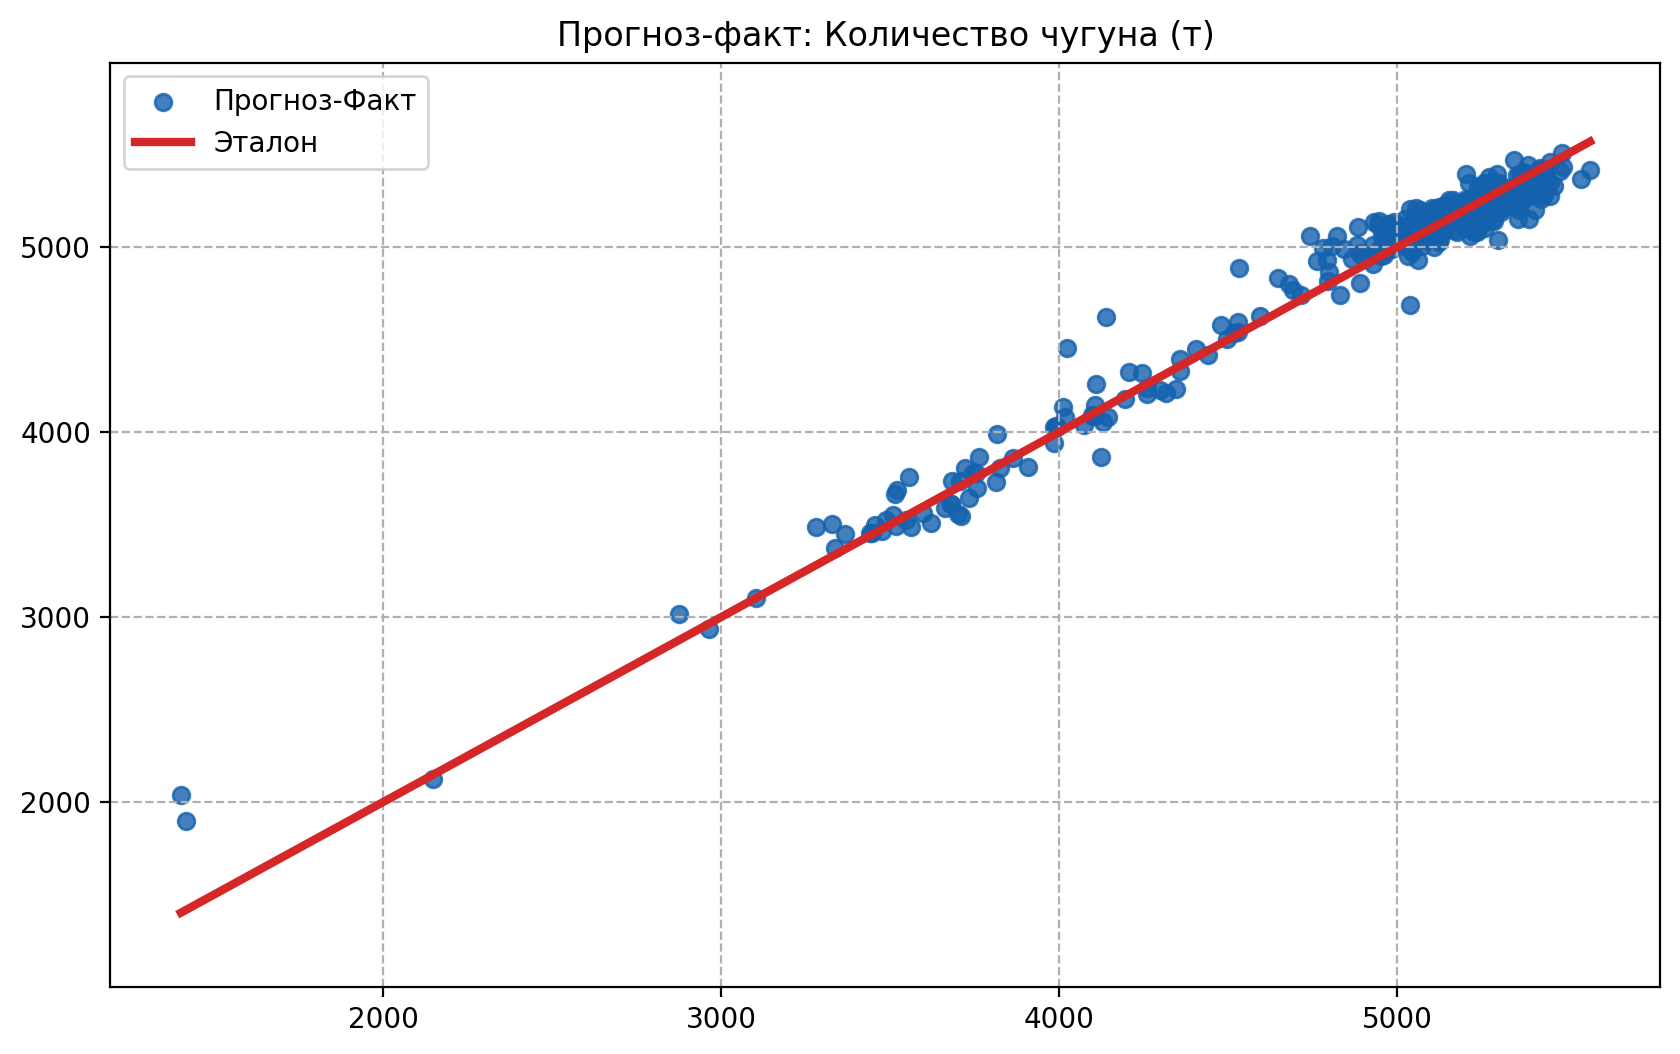

In [39]:
plt.figure(figsize=(10, 6))
plt.ylim(1001, 5999)
plt.scatter(y_test, y_pred, alpha = 0.8, color='#1461AD', label='Прогноз-Факт')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '-', linewidth=3, color='C13733', label='Эталон')
plt.xlabel(None)
plt.ylabel(None)
plt.title('Прогноз-факт: Количество чугуна (т)')
plt.legend()
plt.grid(linestyle='--')
plt.show()

### График важности признаков

In [40]:
importance = pd.DataFrame({'Признак': X_chugun.columns, 'Важность': best_gb.feature_importances_}).sort_values('Важность', ascending=True)

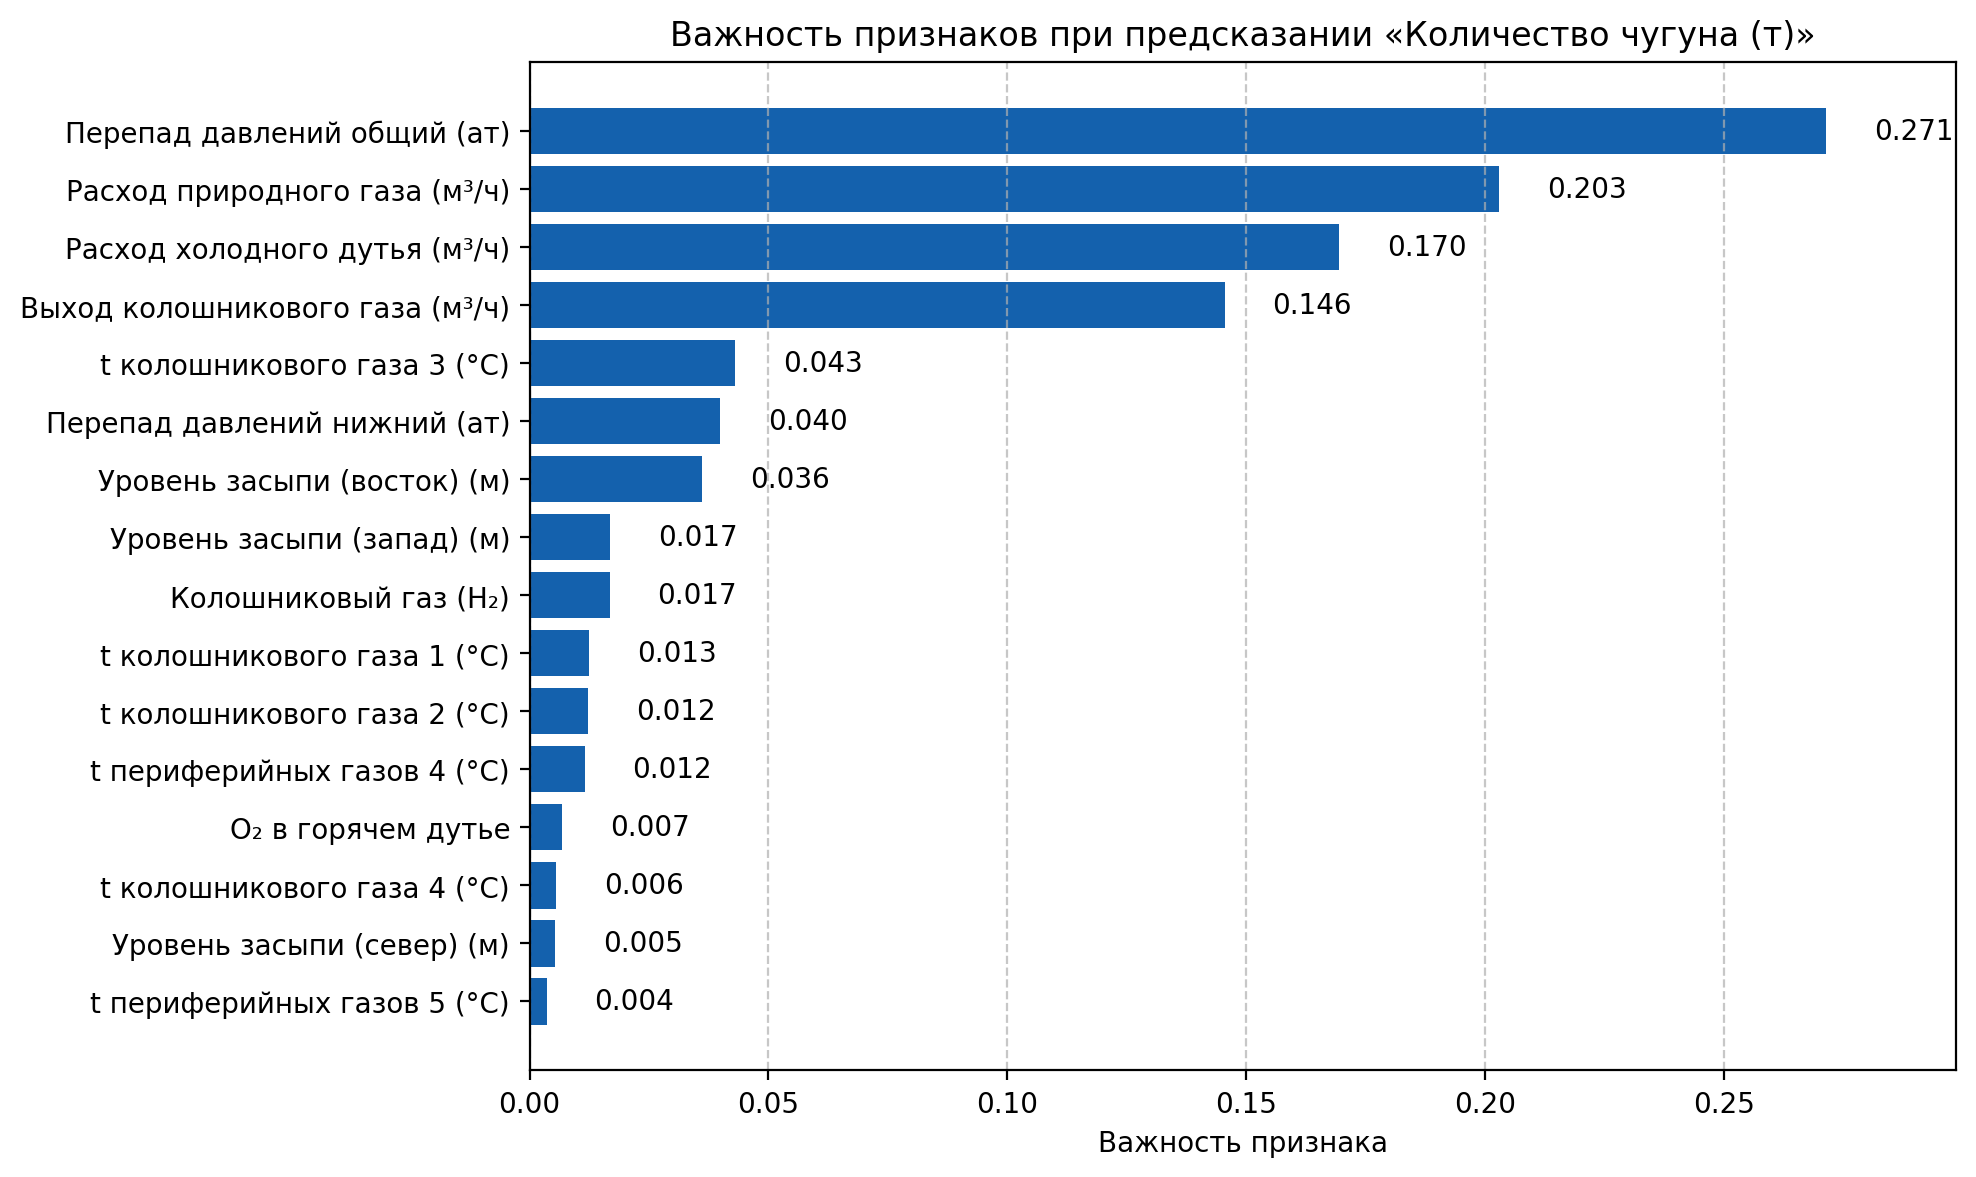

In [41]:
plt.figure(figsize=(10, 6))
plt.xlim(0, importance['Важность'].max() * 1.1)
bars = plt.barh(importance['Признак'], importance['Важность'], color='#1461AD')

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01,bar.get_y() + bar.get_height() / 2,f'{width:.3f}',ha='left',va='center')

plt.xlabel('Важность признака')
plt.title('Важность признаков при предсказании «Количество чугуна (т)»')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Сравнение метрик моделей

In [42]:
y_pred_model = model.predict(X_test)
y_pred_tree = best_tree.predict(X_test)
y_pred_gb = best_gb.predict(X_test)

In [43]:
metrics_model = evaluate_model(y_test, y_pred_model)

Метрики модели:
MAE: 121.31
MSE: 25665.36
MAPE: 0.03%
RMSE: 160.20
R²: 0.94


In [44]:
metrics_tree = evaluate_model(y_test, y_pred_tree)

Метрики модели:
MAE: 122.34
MSE: 40607.58
MAPE: 0.03%
RMSE: 201.51
R²: 0.91


In [45]:
metrics_gb = evaluate_model(y_test, y_pred_gb)

Метрики модели:
MAE: 82.02
MSE: 12881.30
MAPE: 0.02%
RMSE: 113.50
R²: 0.97


In [46]:
all_metrics = {
    'Linear\nRegression': metrics_model,
    'Decision Tree\nRegressor': metrics_tree,
    'Gradient Boosting\nRegressor': metrics_gb
}

In [51]:
metrics_df = pd.DataFrame(all_metrics).T

In [53]:
def convert_to_percentage(df):
    percentage_df = pd.DataFrame()

    for metric in ['MSE', 'MAE', 'MAPE']:
        best_value = df[metric].min()
        percentage_df[metric] = (best_value / df[metric]) * 100

    for metric in ['R2']:
        best_value = df[metric].max()
        percentage_df[metric] = (df[metric] / best_value) * 100

    return percentage_df

In [54]:
percentage_df = convert_to_percentage(metrics_df).T

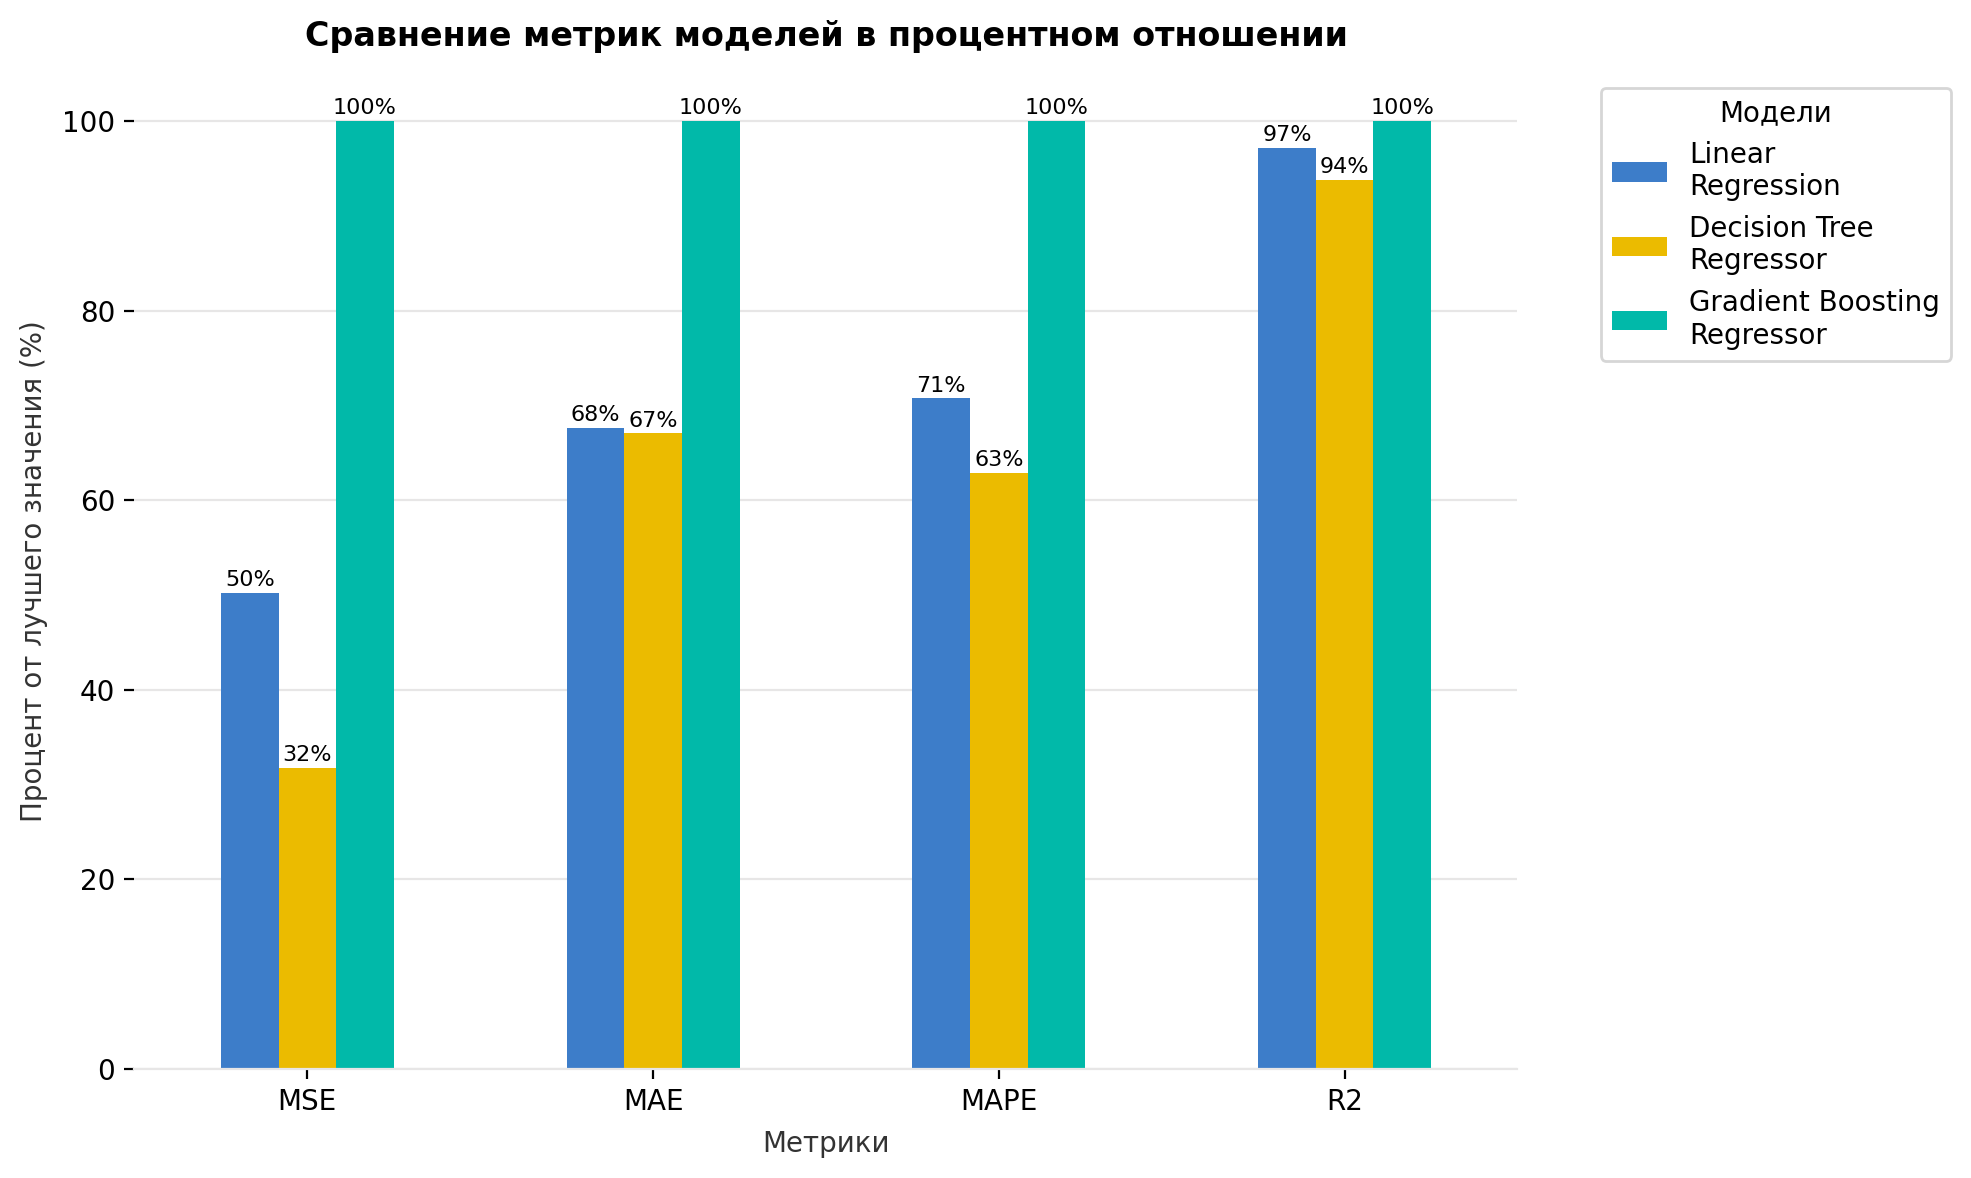

In [91]:
custom_colors = ['#3D7DC9', '#EBBB00', '#01B9A9']  # синий, оранжевый, зелёный
ax = percentage_df.plot(kind='bar', rot=0, figsize=(10, 6), color=custom_colors)
plt.title('Сравнение метрик моделей в процентном отношении', weight='bold', pad=10)
plt.ylabel('Процент от лучшего значения (%)', labelpad=5, alpha=0.8)
plt.xlabel('Метрики', labelpad=5, alpha=0.8)
plt.legend(title='Модели', bbox_to_anchor=(1.05, 1), loc='upper left')

for container in ax.containers:
    ax.bar_label(container, fmt='%.f%%', padding=1, fontsize=8)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#E7E6E6')
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#E7E6E6')
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()

# Модели для таргета «Удельный расход кокса (кг/т)»

## Масштабирование признаков

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X_coke, y_coke, test_size=0.2, random_state=42)

In [57]:
scaler = StandardScaler()

In [58]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Линейная регрессия

### Обучение модели и вывод метрик

In [59]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [60]:
y_pred = model.predict(X_test)

In [61]:
metrics = evaluate_model(y_test, y_pred)

Метрики модели:
MAE: 9.97
MSE: 181.93
MAPE: 0.02%
RMSE: 13.49
R²: 0.65


### График Прогноз-Факт

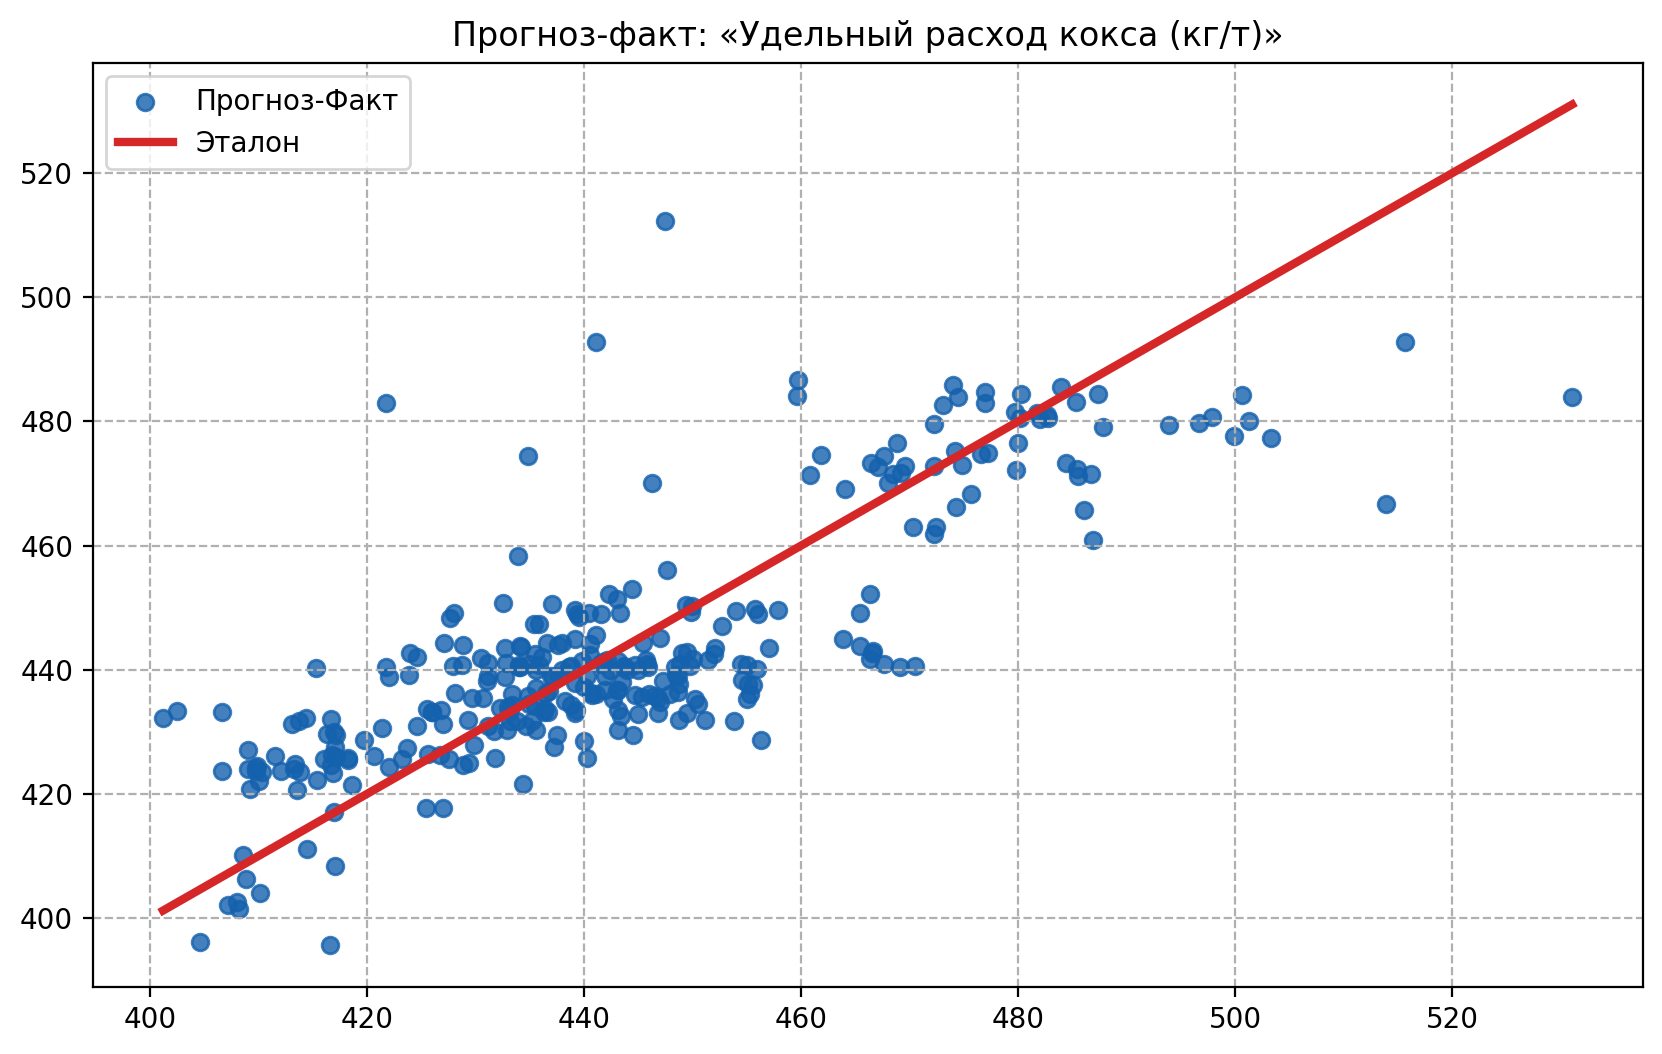

In [62]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha = 0.8, color='#1461AD', label='Прогноз-Факт')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '-', linewidth=3, color='C13733', label='Эталон')
plt.xlabel(None)
plt.ylabel(None)
plt.title('Прогноз-факт: «Удельный расход кокса (кг/т)»')
plt.legend()
plt.grid(linestyle='--')
plt.show()

### График влияния признаков

In [63]:
coefficients = pd.DataFrame({'Признак': X_coke.columns,'Коэффициент': model.coef_}).sort_values(by='Коэффициент', ascending=True)

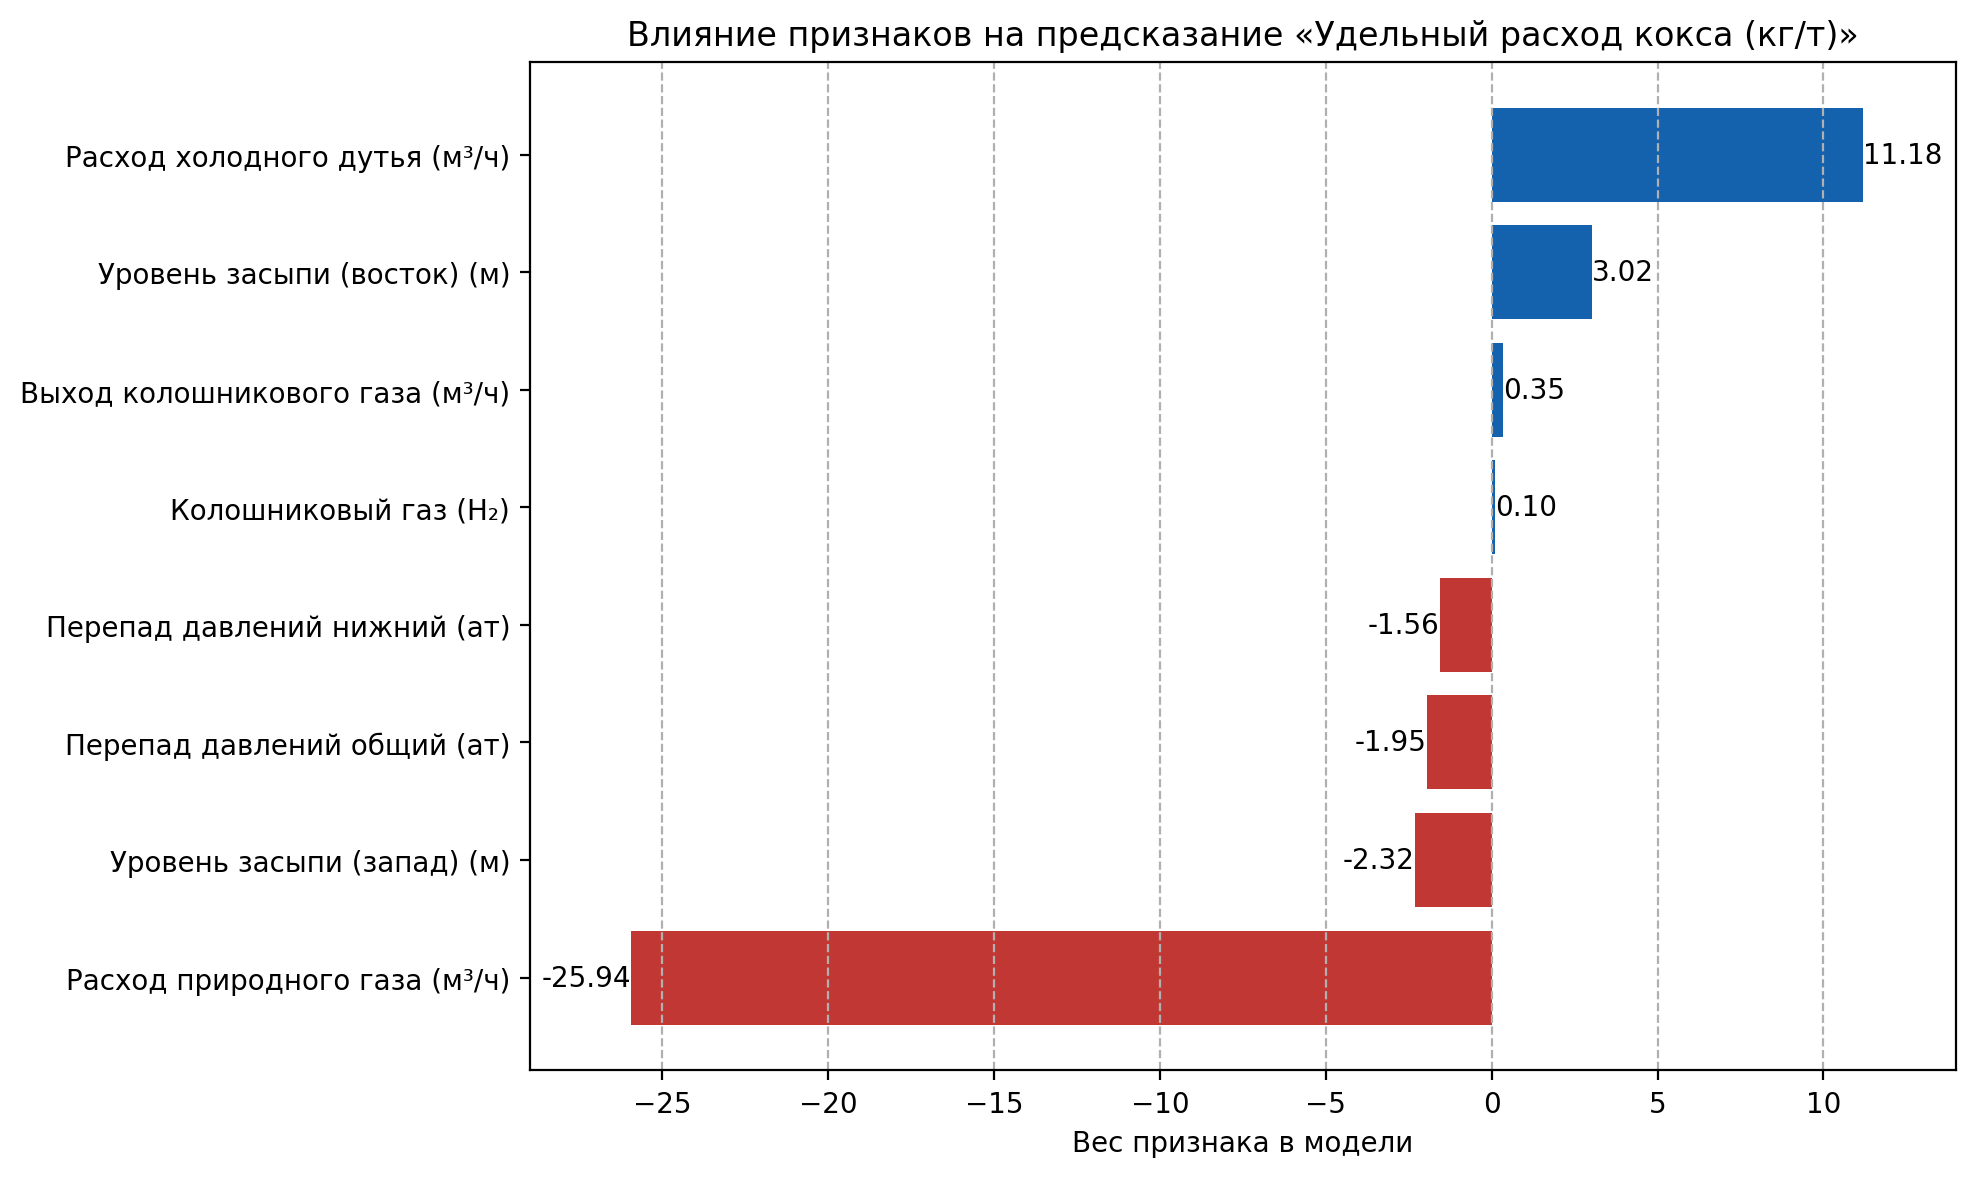

In [64]:
plt.figure(figsize=(10, 6))
plt.xlim(-29, 14)

colors = ['#1461AD' if x >= 0 else '#C13733' for x in coefficients['Коэффициент']]
bars = plt.barh(coefficients['Признак'], coefficients['Коэффициент'], color=colors)

for bar in bars:
    width = bar.get_width()
    align = 'left' if width > 0 else 'right'
    offset = 0.01 if width > 0 else -0.01
    plt.text(width + offset, bar.get_y() + bar.get_height()/2, f'{width:.2f}', ha=align, va='center')

plt.xlabel('Вес признака в модели')
plt.title('Влияние признаков на предсказание «Удельный расход кокса (кг/т)»')
plt.grid(axis='x', linestyle='--', alpha=1)
plt.tight_layout()
plt.show()

## Дерево решений

### Подбор гиперпараметров

In [65]:
tree_model = DecisionTreeRegressor(random_state=42)

In [66]:
# param_grid = {
#     'max_depth': [6, 7, 8],
#     'max_features': ['sqrt', 'log2'],
#     'min_samples_leaf': [3, 4, 5],
#     'min_samples_split': [10, 11, 12]
# }

In [67]:
best_params = {
    'max_depth': [7],
    'max_features': ['log2'],
    'min_samples_leaf': [4],
    'min_samples_split': [11]
}

In [68]:
grid_search = GridSearchCV(
    estimator=tree_model,
    param_grid=best_params,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1
)

In [69]:
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


{'max_depth': 7,
 'max_features': 'log2',
 'min_samples_leaf': 4,
 'min_samples_split': 11}

### Обучение модели и вывод метрик

In [70]:
best_tree = grid_search.best_estimator_

In [71]:
y_pred = best_tree.predict(X_test)

In [72]:
metrics = evaluate_model(y_test, y_pred)

Метрики модели:
MAE: 9.74
MSE: 180.80
MAPE: 0.02%
RMSE: 13.45
R²: 0.66


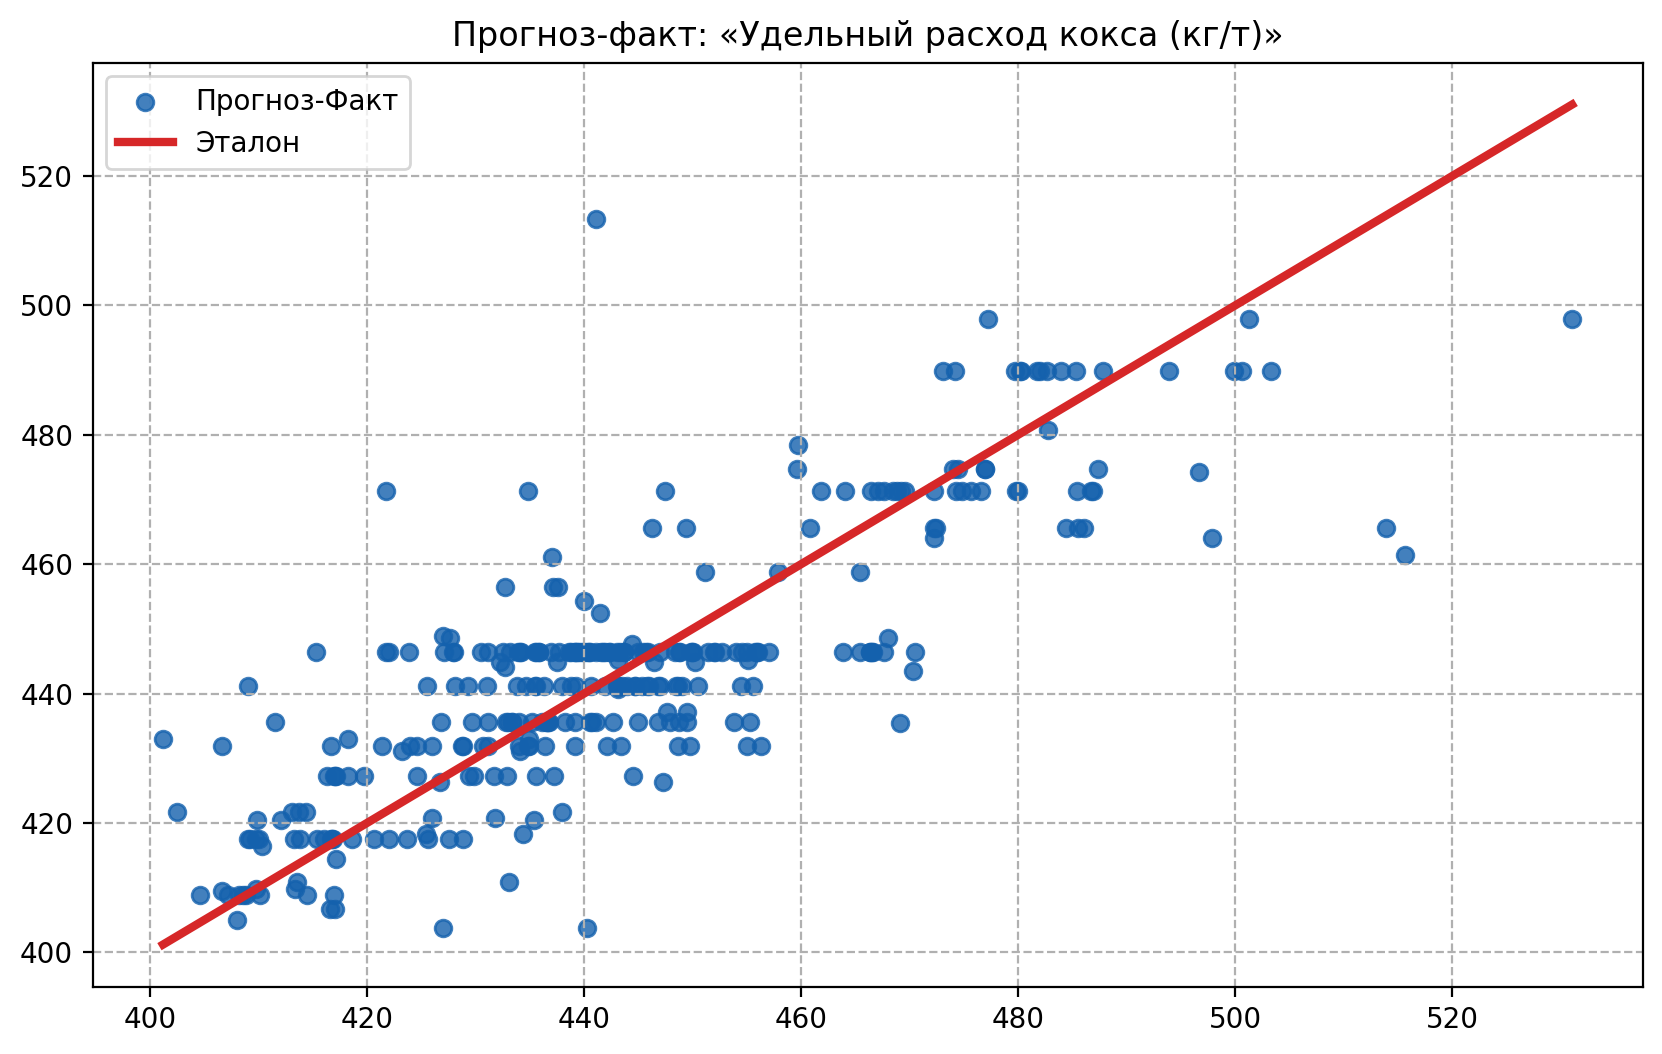

In [73]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha = 0.8, color='#1461AD', label='Прогноз-Факт')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '-', linewidth=3, color='C13733', label='Эталон')
plt.xlabel(None)
plt.ylabel(None)
plt.title('Прогноз-факт: «Удельный расход кокса (кг/т)»')
plt.legend()
plt.grid(linestyle='--')
plt.show()

### График важности признаков

In [74]:
importance = pd.DataFrame({'Признак': X_coke.columns, 'Важность': best_tree.feature_importances_}).sort_values('Важность', ascending=True)

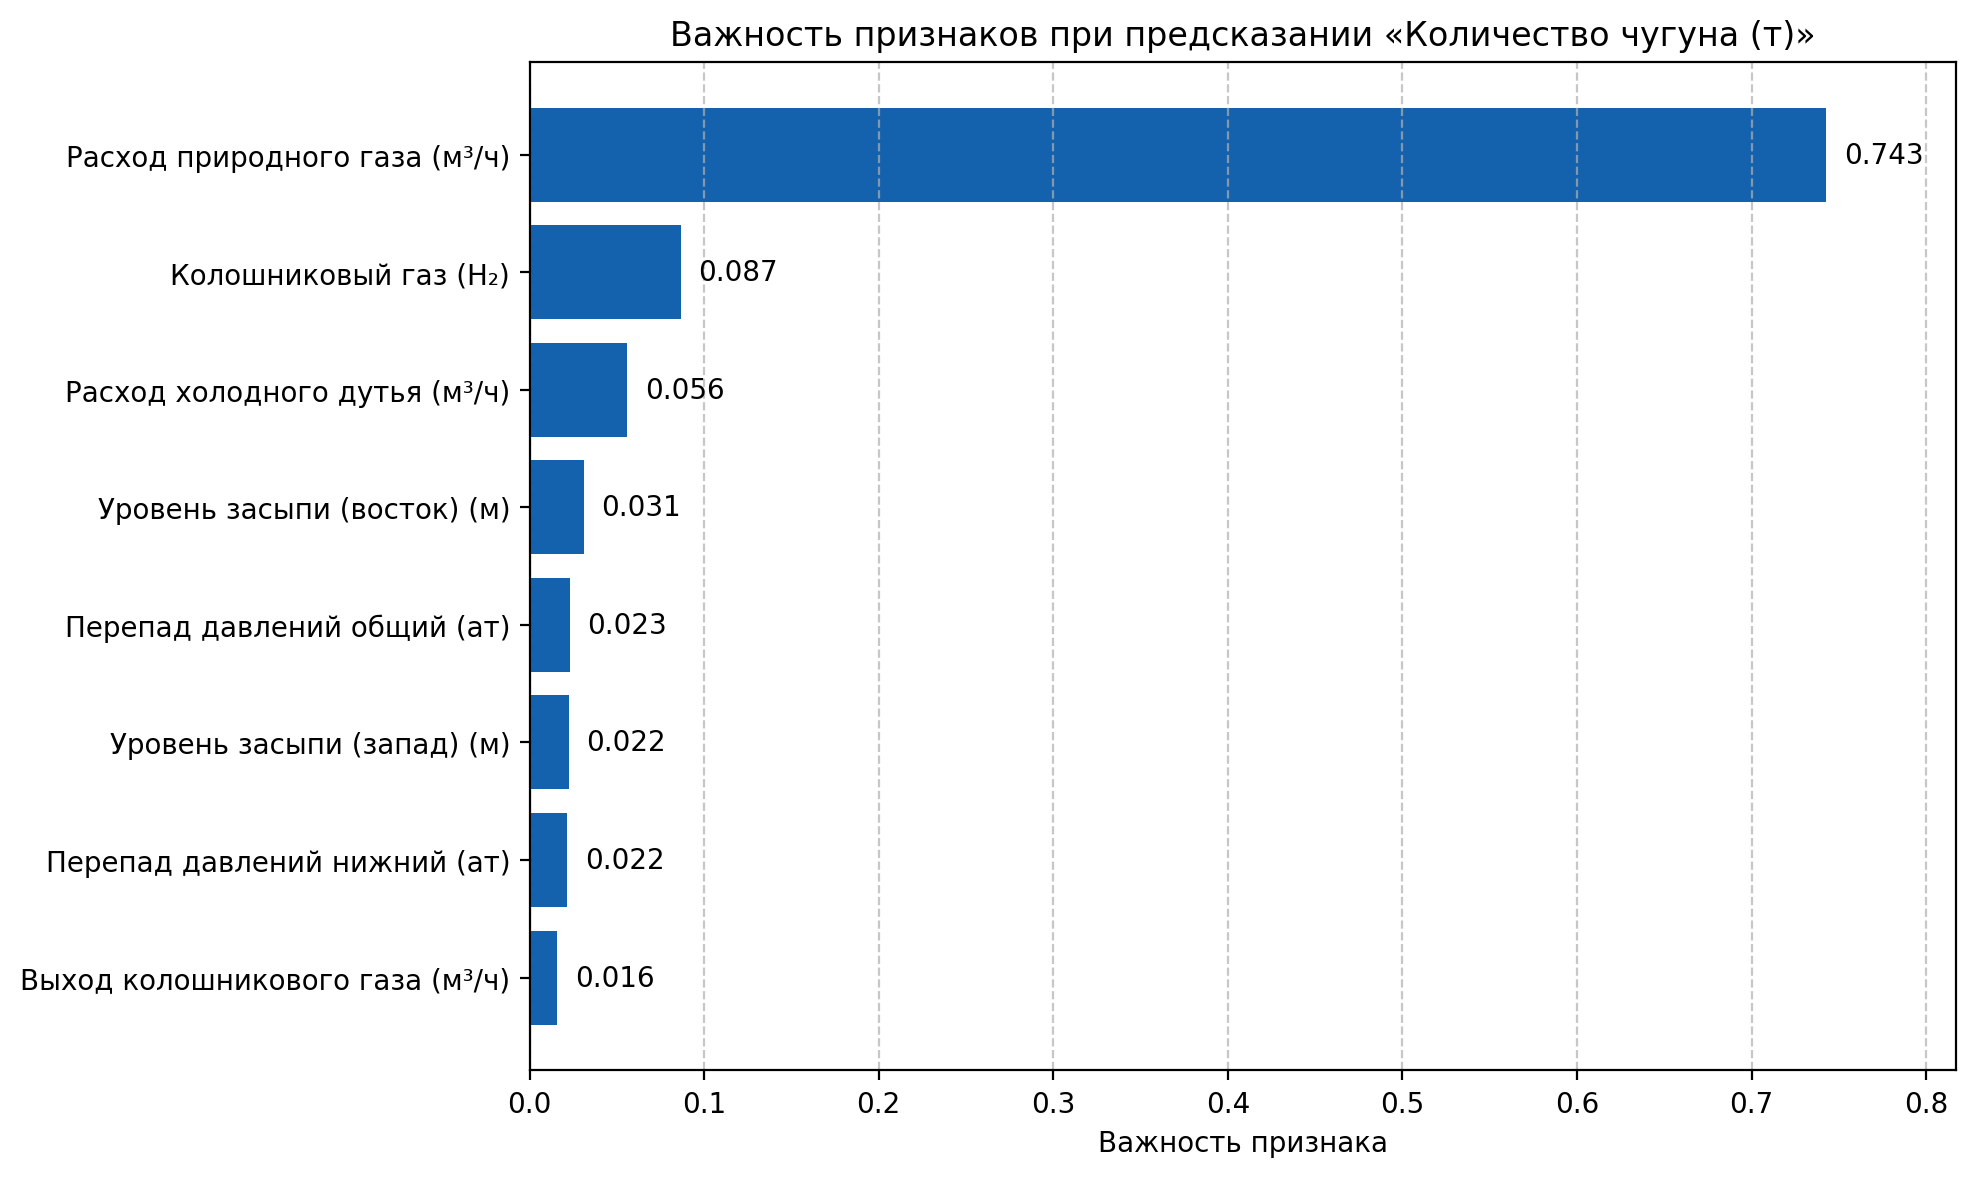

In [75]:
plt.figure(figsize=(10, 6))
plt.xlim(0, importance['Важность'].max() * 1.1)
bars = plt.barh(importance['Признак'], importance['Важность'], color='#1461AD')

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01,bar.get_y() + bar.get_height() / 2,f'{width:.3f}',ha='left',va='center')

plt.xlabel('Важность признака')
plt.title('Важность признаков при предсказании «Количество чугуна (т)»')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Визуализация дерева решений

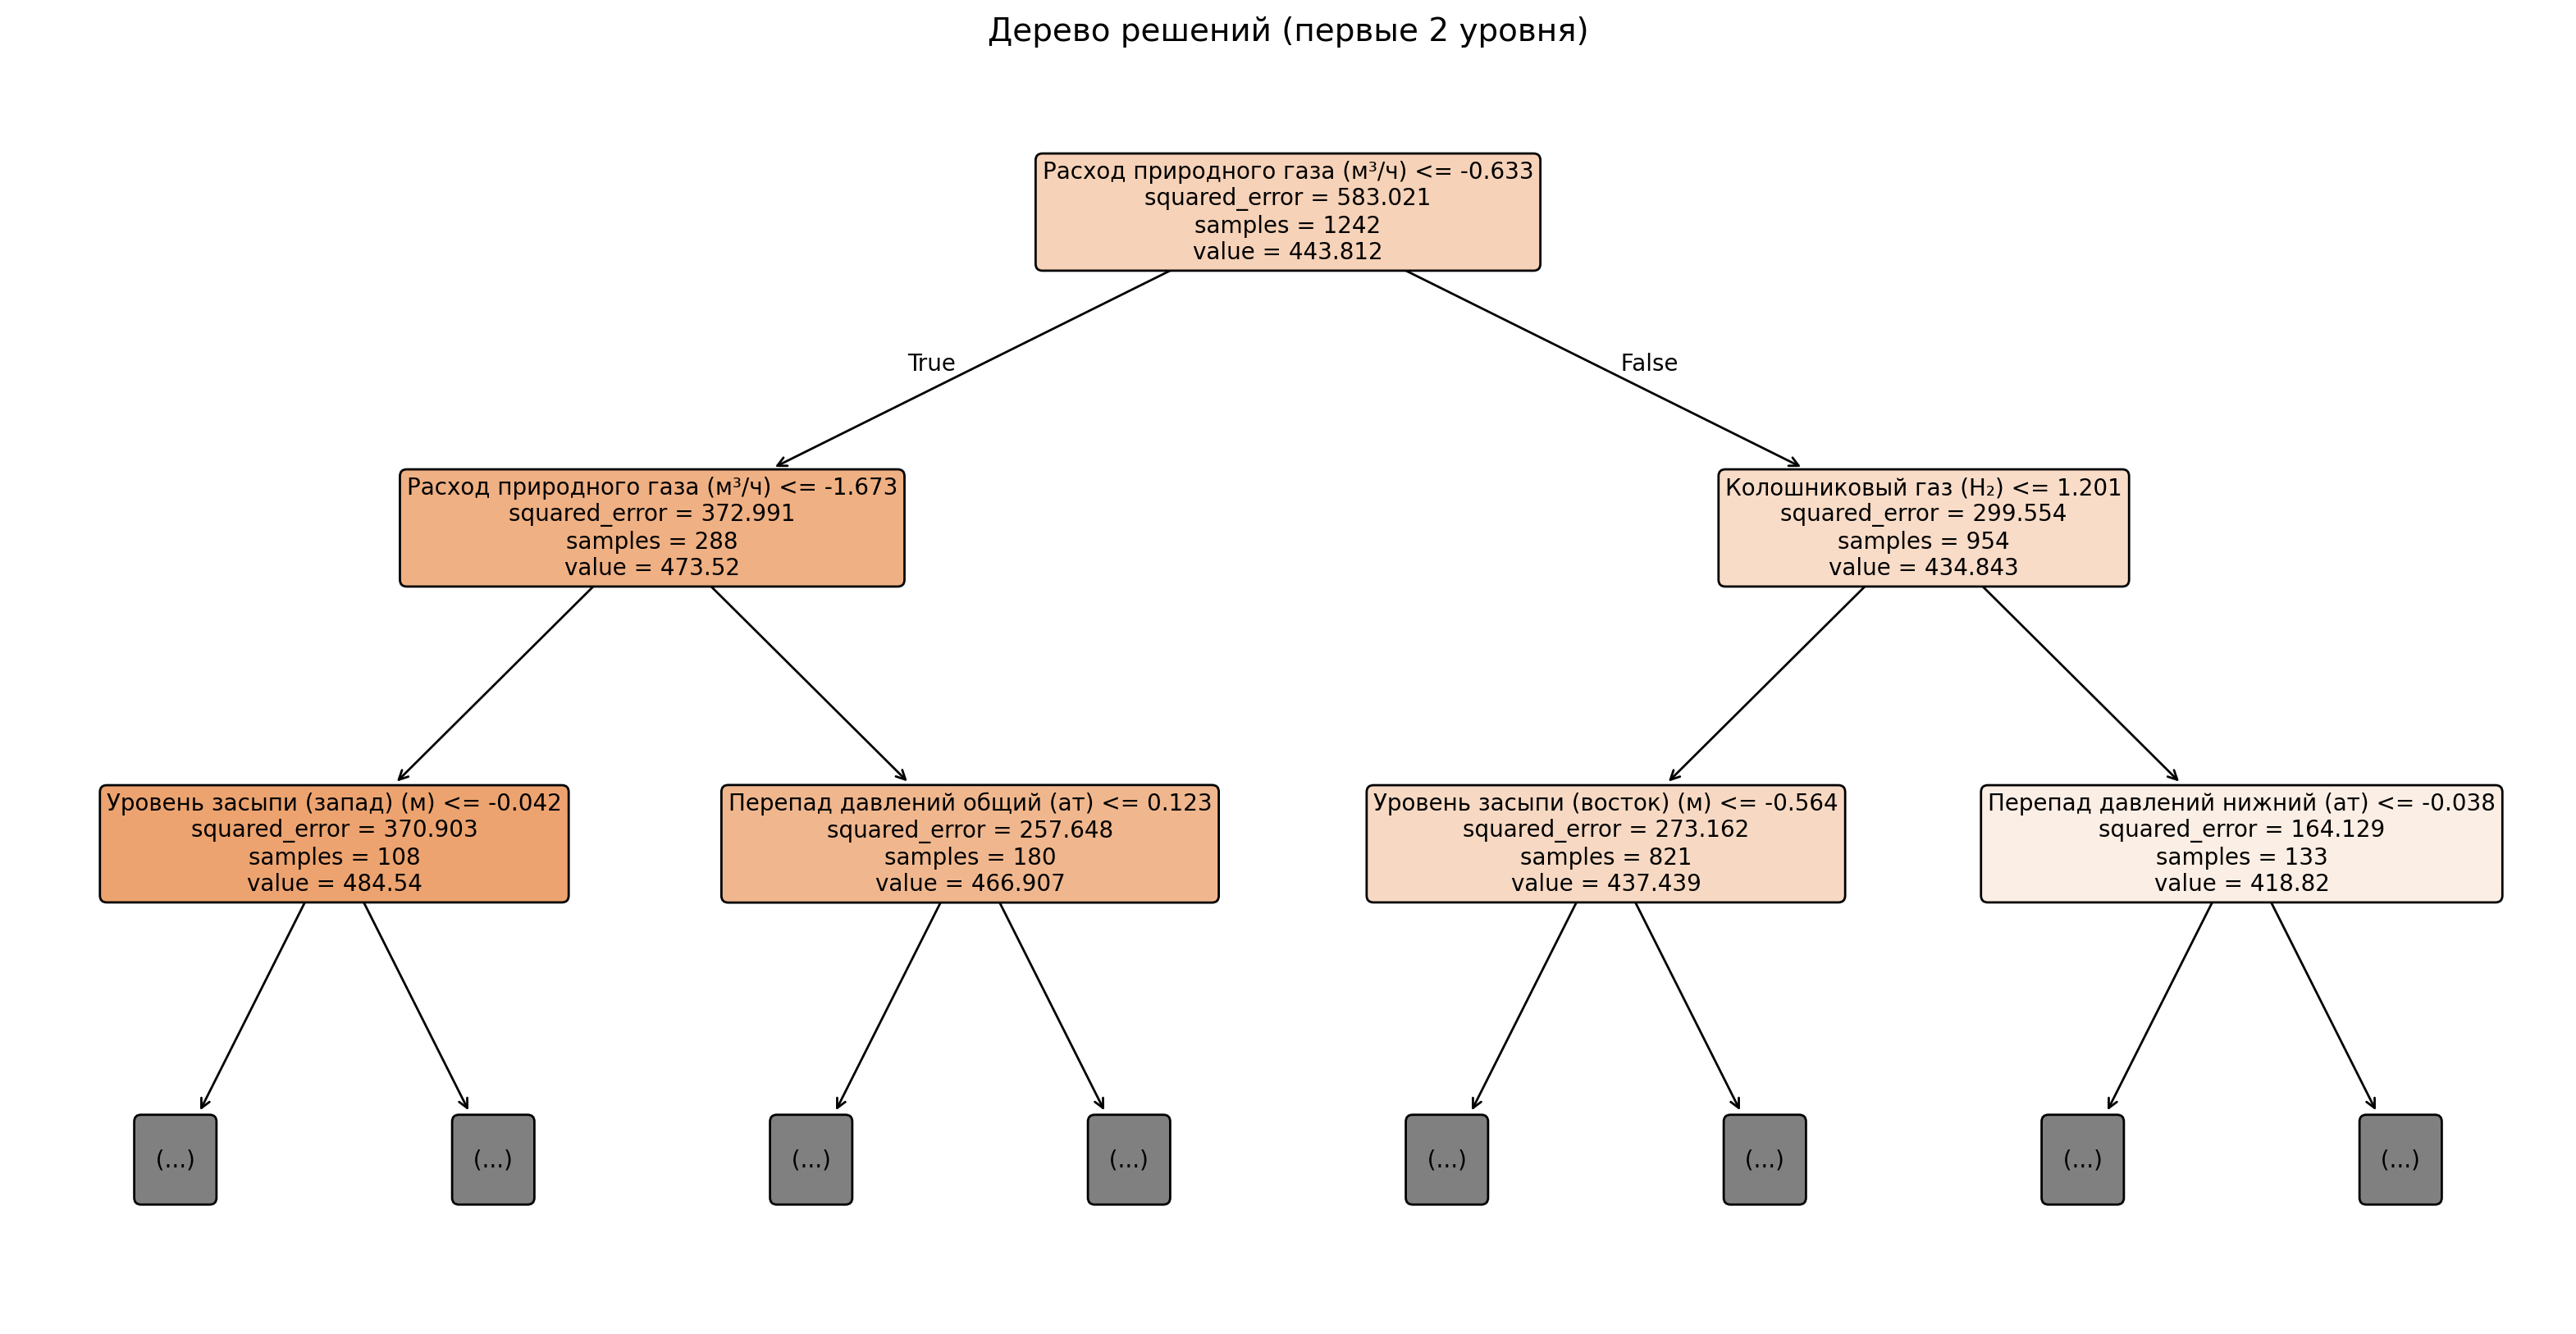

In [76]:
plt.figure(figsize=(20, 10))
plot_tree(
    best_tree,
    feature_names=importance['Признак'],
    filled=True,
    rounded=True,
    fontsize=10,
    max_depth=2,
)
plt.title("Дерево решений (первые 2 уровня)", fontsize=14)
plt.show()

## Градиентный бустинг

### Подбор гиперпараметров

In [101]:
gb_model = GradientBoostingRegressor(random_state=42)

In [102]:
# param_grid = {
#     'learning_rate': [0.19, 0.2, 0.21],
#     'max_depth': [7, 8, 9],
#     'max_features': ['sqrt', 'log2'],
#     'min_samples_leaf': [1, 2, 3],
#     'min_samples_split': [7, 8, 9],
#     'n_estimators': [15, 16, 17]
# }

In [112]:
best_params = {
    'learning_rate': [0.19, 0.2, 0.21],
    'max_depth': [8],
    'max_features': ['log2'],
    'min_samples_leaf': [2],
    'min_samples_split': [8],
    'n_estimators': [15, 16, 17]
}

In [113]:
grid_search = GridSearchCV(
    estimator=gb_model,
    param_grid=best_params,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
)

In [114]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             param_grid={'learning_rate': [0.19, 0.2, 0.21], 'max_depth': [8],
                         'max_features': ['log2'], 'min_samples_leaf': [2],
                         'min_samples_split': [8],
                         'n_estimators': [15, 16, 17]},
             scoring='neg_mean_squared_error', verbose=1)

In [115]:
best_params = grid_search.best_params_
best_params

{'learning_rate': 0.2,
 'max_depth': 8,
 'max_features': 'log2',
 'min_samples_leaf': 2,
 'min_samples_split': 8,
 'n_estimators': 16}

### Обучение модели и вывод метрик

In [116]:
best_gb = grid_search.best_estimator_

In [117]:
y_pred = best_gb.predict(X_test)

In [118]:
metrics = evaluate_model(y_test, y_pred)

Метрики модели:
MAE: 8.01
MSE: 131.05
MAPE: 0.02%
RMSE: 11.45
R²: 0.75


### График Прогноз-Факт

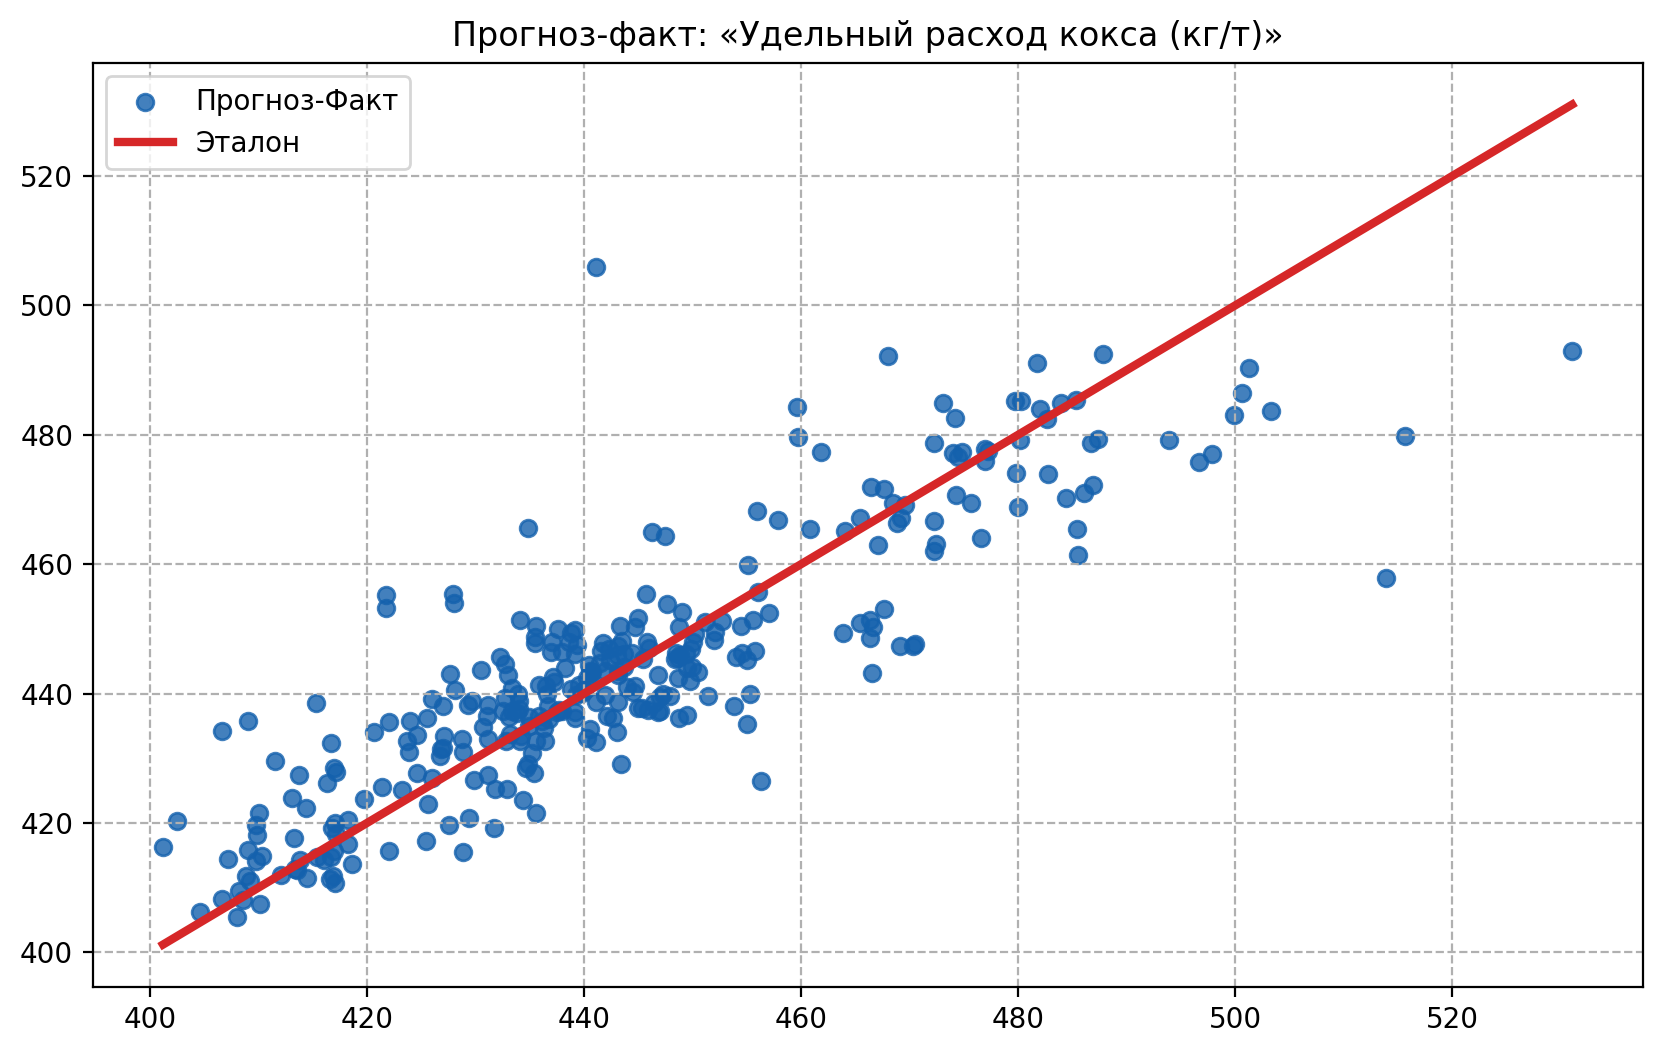

In [119]:
plt.figure(figsize=(10, 6))

plt.scatter(y_test, y_pred, alpha = 0.8, color='#1461AD', label='Прогноз-Факт')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '-', linewidth=3, color='C13733', label='Эталон')
plt.xlabel(None)
plt.ylabel(None)
plt.title('Прогноз-факт: «Удельный расход кокса (кг/т)»')
plt.legend()
plt.grid(linestyle='--')
plt.show()

### График важности признаков

In [120]:
importance = pd.DataFrame({'Признак': X_coke.columns, 'Важность': best_gb.feature_importances_}).sort_values('Важность', ascending=True)

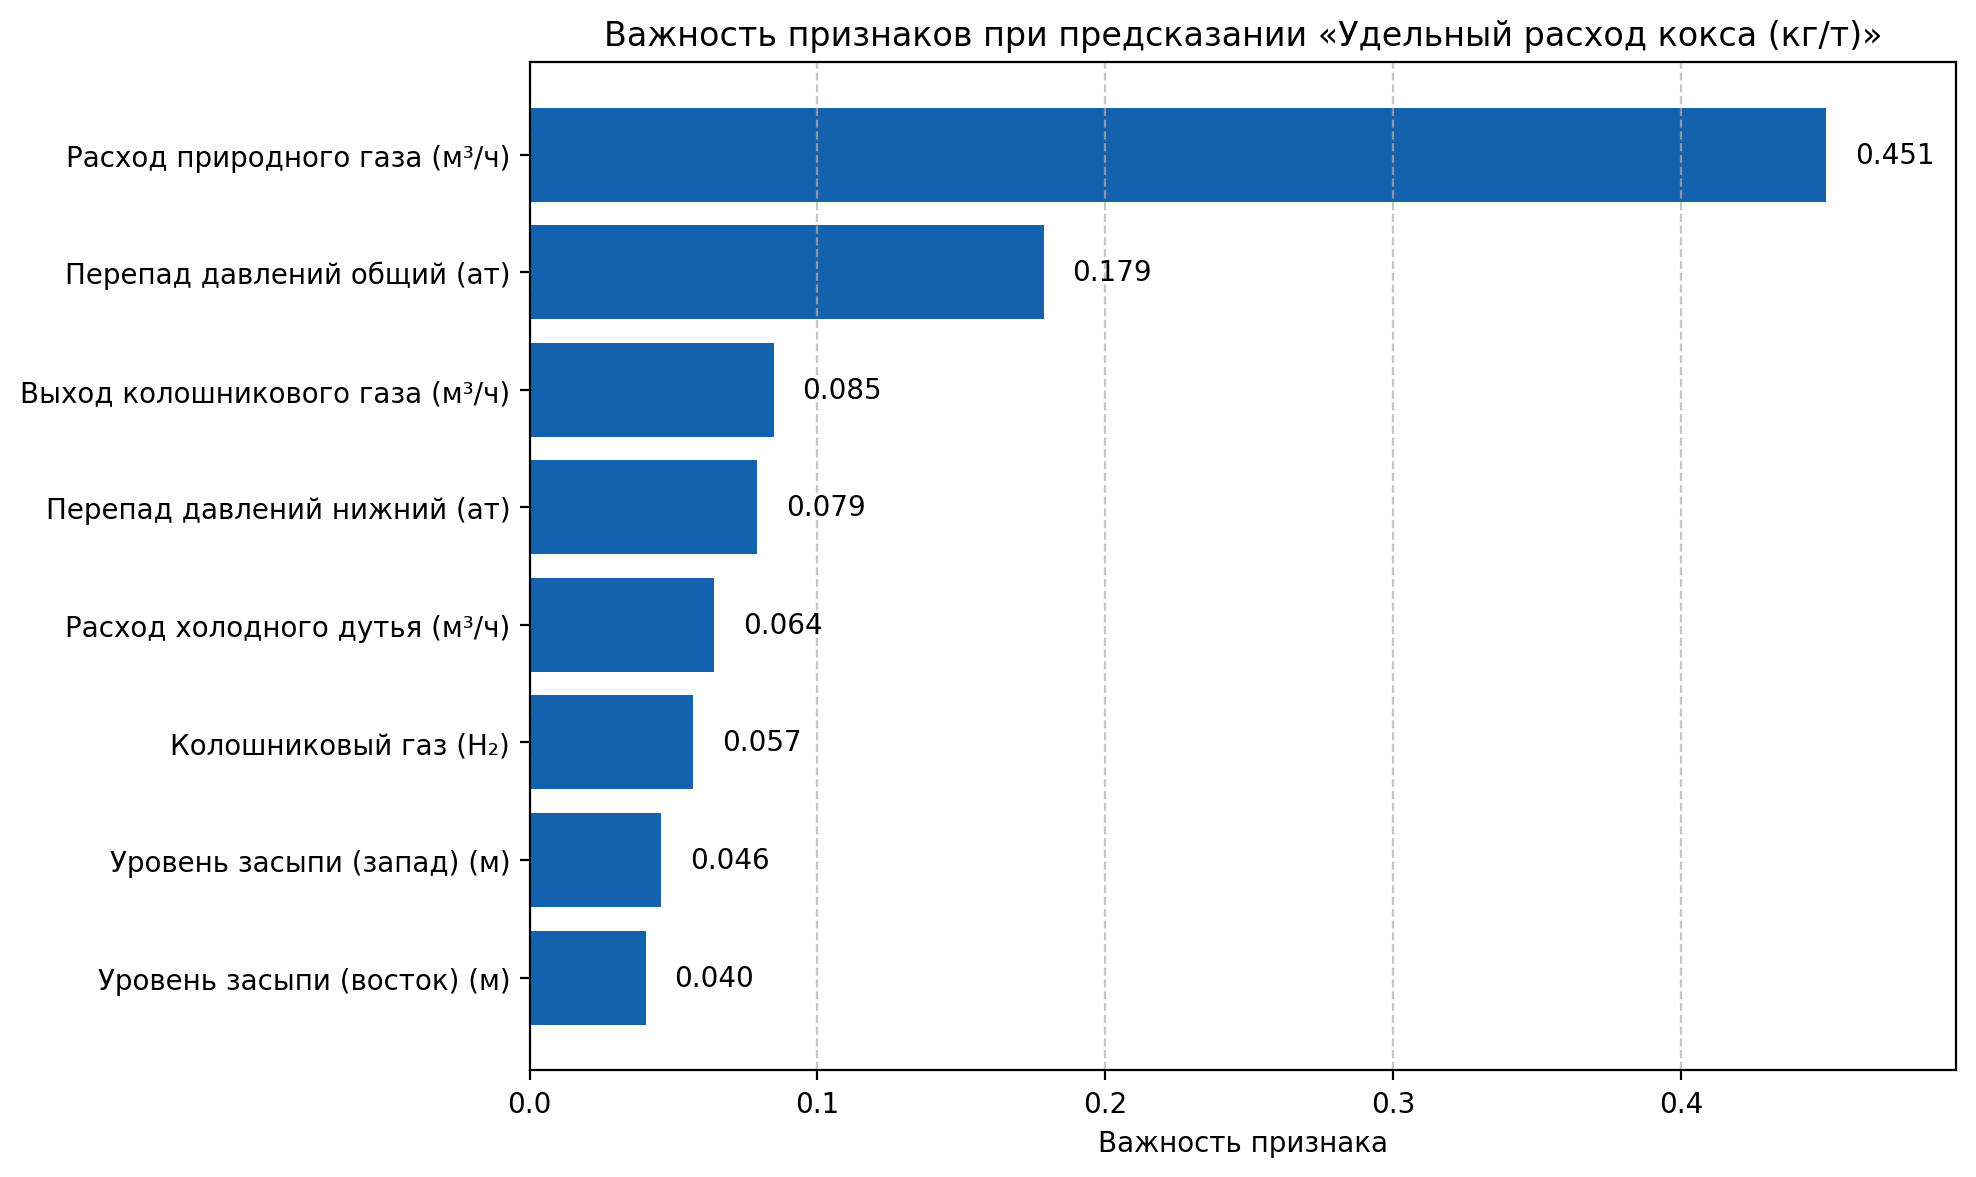

In [121]:
plt.figure(figsize=(10, 6))
plt.xlim(0, importance['Важность'].max() * 1.1)
bars = plt.barh(importance['Признак'], importance['Важность'], color='#1461AD')

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01,bar.get_y() + bar.get_height() / 2,f'{width:.3f}',ha='left',va='center')

plt.xlabel('Важность признака')
plt.title('Важность признаков при предсказании «Удельный расход кокса (кг/т)»')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Сравнение метрик моделей

In [122]:
y_pred_model = model.predict(X_test)
y_pred_tree = best_tree.predict(X_test)
y_pred_gb = best_gb.predict(X_test)

In [123]:
metrics_model = evaluate_model(y_test, y_pred_model)

Метрики модели:
MAE: 9.97
MSE: 181.93
MAPE: 0.02%
RMSE: 13.49
R²: 0.65


In [124]:
metrics_tree = evaluate_model(y_test, y_pred_tree)

Метрики модели:
MAE: 9.74
MSE: 180.80
MAPE: 0.02%
RMSE: 13.45
R²: 0.66


In [125]:
metrics_gb = evaluate_model(y_test, y_pred_gb)

Метрики модели:
MAE: 8.01
MSE: 131.05
MAPE: 0.02%
RMSE: 11.45
R²: 0.75


In [126]:
all_metrics = {
    'Linear\nRegression': metrics_model,
    'Decision Tree\nRegressor': metrics_tree,
    'Gradient Boosting\nRegressor': metrics_gb
}

In [127]:
metrics_df = pd.DataFrame(all_metrics).T

In [128]:
def convert_to_percentage(df):
    percentage_df = pd.DataFrame()

    for metric in ['MSE', 'MAE', 'MAPE']:
        best_value = df[metric].min()
        percentage_df[metric] = (best_value / df[metric]) * 100

    for metric in ['R2']:
        best_value = df[metric].max()
        percentage_df[metric] = (df[metric] / best_value) * 100

    return percentage_df

In [129]:
percentage_df = convert_to_percentage(metrics_df).T

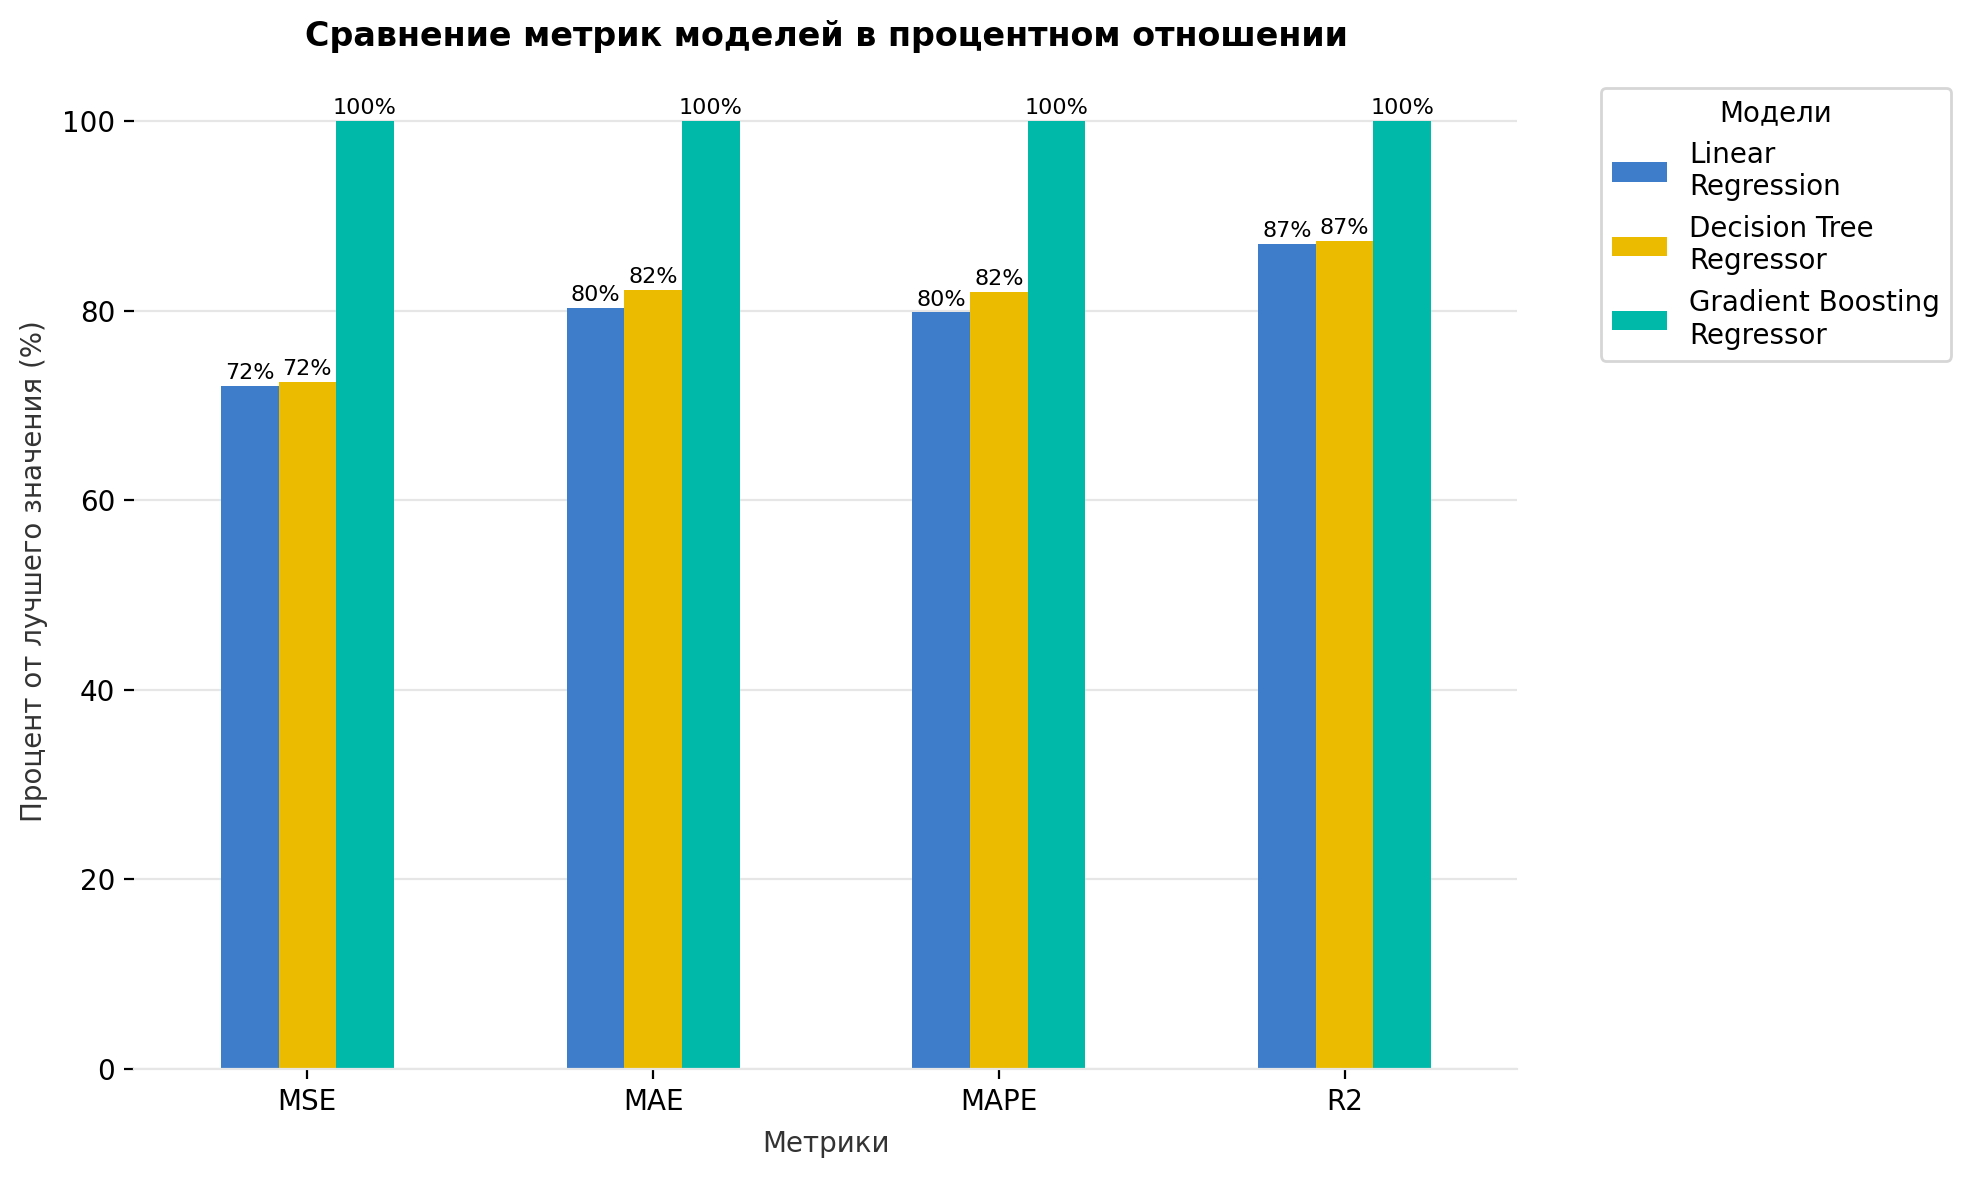

In [130]:
custom_colors = ['#3D7DC9', '#EBBB00', '#01B9A9']  # синий, оранжевый, зелёный
ax = percentage_df.plot(kind='bar', rot=0, figsize=(10, 6), color=custom_colors)
plt.title('Сравнение метрик моделей в процентном отношении', weight='bold', pad=10)
plt.ylabel('Процент от лучшего значения (%)', labelpad=5, alpha=0.8)
plt.xlabel('Метрики', labelpad=5, alpha=0.8)
plt.legend(title='Модели', bbox_to_anchor=(1.05, 1), loc='upper left')

for container in ax.containers:
    ax.bar_label(container, fmt='%.f%%', padding=1, fontsize=8)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#E7E6E6')
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#E7E6E6')
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()